# Analysis of processed data

In [1]:
import copy, os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
import re
import lir

from scipy import stats
from scipy.stats import gaussian_kde, ttest_ind, rankdata, norm, false_discovery_control
from scipy.spatial.distance import pdist, squareform

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, Normalizer, scale
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics.pairwise import paired_manhattan_distances
from sklearn.svm import SVC

from random import choices
from random import seed

from lir.transformers import PercentileRankTransformer
from lir import to_odds

from numpy.linalg import matrix_power, inv
from itertools import combinations
from tqdm.auto import tqdm
from xgboost import XGBClassifier

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

## Import data

### Select dataset

Open the csv file with the data which you want to analyze. The following options are possible:
* Data_Polymers (uncorrected data)
* Data_Polymers_C (data normalized to C signal)
* Data_Polymers_glass (data (semi-)quantified with NIST SRM 612 standard, raw signal divided by signal standard)
* Data_Polymers_PVC (data quantified with PVC standard in mg/kg)
* Data_Polymers_PVC_C (data normalized to C signal and (semi-)quantified with PVC standard in mg/kg)

In [3]:
data_FO_processed = (pd.read_csv('df/Data_Polymers.csv', sep = ',')).pivot_table(index=["Polymer", "Source","Day2","Batch","Color","N"])
data_FO_processed

Al27         As75          Ba138  \
Polymer Source Day2 Batch Color  N                                             
Can     1      1    A     Black  1  4.514513e+05  2424.022697   86832.257747   
                                 2  2.649830e+05  2010.655483  113244.518728   
                                 3  3.659630e+05  1982.227454  126763.638529   
                                 4  2.403186e+05  2078.278705   85428.380212   
               2    A     Black  1  4.742555e+05   454.148398   74589.797046   
...                                          ...          ...            ...   
Wire    49     1    A     Yellow 4  6.260520e+05  2449.337480   38155.721808   
               2    A     Yellow 1  7.211286e+05  1918.783449   52927.602727   
                                 2  1.268050e+06  2072.578929   83856.410263   
                                 3  6.270178e+05  1772.158243   40769.225489   
                                 4  6.816793e+05  1463.358616   37683.452751   

                                            Ca44           Cu63          Fe57  \
Polymer Source Day2 Batch Color  N                                              
Can     1      1    A     Black  1  1.156666e+06   98427.319507  36682.518303   
                                 2  1.192630e+06  101432.243981  32799.164407   
                                 3  1.179015e+06  100321.324477  45477.240574   
                                 4  1.205820e+06   97302.642666  44369.432417   
               2    A     Black  1  9.902725e+05   89048.742400  43832.276618   
...                                          ...            ...           ...   
Wire    49     1    A     Yellow 4  4.420022e+07   14561.255521  80812.833536   
               2    A     Yellow 1  4.210882e+07   14997.490717  77099.098742   
                                 2  4.983738e+07   19201.416678  87897.146067   
                                 3  4.757561e+07   22478.465137  87302.818301   
                                 4  4.503496e+07   12912.982289  81029.085051   

                                             K39           Mg25  \
Polymer Source Day2 Batch Color  N                                
Can     1      1    A     Black  1  2.673996e+05   12105.466885   
                                 2  1.375284e+05   12876.598394   
                                 3  1.754441e+05   10404.698679   
                                 4  1.038278e+05    9366.842277   
               2    A     Black  1  2.112191e+05   13120.011733   
...                                          ...            ...   
Wire    49     1    A     Yellow 4  4.484523e+05  666638.362292   
               2    A     Yellow 1  5.741748e+05  750185.849410   
                                 2  1.049662e+06  766291.161143   
                                 3  4.731333e+05  733973.700897   
                                 4  4.203999e+05  676966.875409   

                                             Mn55           Na23  \
Polymer Source Day2 Batch Color  N                                 
Can     1      1    A     Black  1   44082.572733   56841.704042   
                                 2   39485.795384   48238.705174   
                                 3   53590.660179   66655.715274   
                                 4   55179.628033   42589.440131   
               2    A     Black  1   34579.652692   59406.208408   
...                                           ...            ...   
Wire    49     1    A     Yellow 4  137095.732325  241226.265339   
               2    A     Yellow 1  123392.992913  272082.121049   
                                 2  140573.952415  350748.483015   
                                 3  155588.712507  267475.081084   
                                 4  123298.645865  225408.827133   

                                            Nb93         Ni60         Pb208  \
Polymer Source Day2 Batch Color  N                                            
Can     1      1    A     Black  1

In this step the specific type of object can be selected and the number of elements.

In [4]:
# Select dataset with specific normalization and quantification method
data_FO_select = data_FO_processed

#Select elements and type of forensic object: tapes, wires, tubing, (Jerry) Can
data_x = (data_FO_select
              .reset_index()
#              .drop(columns=['Ba138','K39','Na23','Ni60','Sb121','Nb93','Ti47','Mn55','Sr88']) #Can be removed to have 9 features, because those columns have low values or low between/within ratio in all objects
              .loc[data_FO_select.reset_index()['Polymer'].str.contains('Can')]
              .pivot_table(index=['Polymer', 'Source','Day2', 'Batch', "Color", 'N'])
              .sort_values(["Source","Batch","Day2","N"])
         )[sorted(data_FO_select.columns, key=lambda x: int(re.search(r'\d+', x).group()))]

data_x

Na23          Mg25  \
Polymer Source Day2 Batch Color       N                               
Can     1      1    A     Black       1  56841.704042  12105.466885   
                                      2  48238.705174  12876.598394   
                                      3  66655.715274  10404.698679   
                                      4  42589.440131   9366.842277   
               2    A     Black       1  59406.208408  13120.011733   
...                                               ...           ...   
        39     1    A     Transparent 4      0.000001      0.000001   
               2    A     Transparent 1  15373.202607    318.760086   
                                      2   3117.850315    150.534607   
                                      3   2022.020805    153.018243   
                                      4   3032.211252    174.850184   

                                                  Al27          Si29  \
Polymer Source Day2 Batch Color       N                                
Can     1      1    A     Black       1  451451.337642  38445.552027   
                                      2  264982.951709  37575.190459   
                                      3  365963.047724  38472.150295   
                                      4  240318.625078  33712.701265   
               2    A     Black       1  474255.541517  41617.892665   
...                                                ...           ...   
        39     1    A     Transparent 4     221.971371   3928.333744   
               2    A     Transparent 1    4303.941313  12919.679052   
                                      2    3396.918199  24320.277444   
                                      3    4220.864333  28056.661061   
                                      4    2746.567117  27258.246850   

                                                   K39          Ca44  \
Polymer Source Day2 Batch Color       N                                
Can     1      1    A     Black       1  267399.612218  1.156666e+06   
                                      2  137528.430648  1.192630e+06   
                                      3  175444.092006  1.179015e+06   
                                      4  103827.777091  1.205820e+06   
               2    A     Black       1  211219.077187  9.902725e+05   
...                                                ...           ...   
        39     1    A     Transparent 4       0.000001  2.386739e+03   
               2    A     Transparent 1   11656.331414  2.083276e+04   
                                      2    5377.117273  1.874421e+04   
                                      3    8283.873378  1.924542e+04   
                                      4    6208.213105  1.804167e+04   

                                                  Ti47          Mn55  \
Polymer Source Day2 Batch Color       N                                
Can     1      1    A     Black       1  500023.593316  44082.572733   
                                      2  503009.895749  39485.795384   
                                      3  531205.667919  53590.660179   
                                      4  513990.273923  55179.628033   
               2    A     Black       1  578351.405137  34579.652692   
...                                                ...           ...   
        39     1    A     Transparent 4      43.012731      7.345100   
               2    A     Transparent 1     602.264449      0.000001   
                                      2     216.633116      0.000001   
                                      3     265.285150    183.532861   
                                      4     312.640380    175.303210   

                                                 Fe57        Ni60  \
Polymer Source Day2 Batch Color       N                             
Can     1      1    A     Black       1  36682.518303  938.330928   
                                      2  32799.164407  799.352018   
                                      

In [5]:
#Mean data
data_mean = data_x.groupby(['Polymer', 'Source','Color']).agg('mean')

### Log transformed dataset

In [6]:
data_log = (
    np.log10(data_x)
    .replace([-np.inf], 10)
)

data_log

Na23      Mg25      Al27  \
Polymer Source Day2 Batch Color       N                                 
Can     1      1    A     Black       1  4.754667  4.082982  5.654611   
                                      2  4.683396  4.109801  5.423218   
                                      3  4.823837  4.017230  5.563437   
                                      4  4.629302  3.971593  5.380787   
               2    A     Black       1  4.773832  4.117934  5.676012   
...                                           ...       ...       ...   
        39     1    A     Transparent 4 -6.000000 -6.000000  2.346297   
               2    A     Transparent 1  4.186764  2.503464  3.633866   
                                      2  3.493855  2.177636  3.531085   
                                      3  3.305786  2.184743  3.625401   
                                      4  3.481759  2.242666  3.438790   

                                             Si29       K39      Ca44  \
Polymer Source Day2 Batch Color       N                                 
Can     1      1    A     Black       1  4.584846  5.427161  6.063208   
                                      2  4.574901  5.138392  6.076506   
                                      3  4.585146  5.244139  6.071519   
                                      4  4.527794  5.016314  6.081283   
               2    A     Black       1  4.619280  5.324733  5.995755   
...                                           ...       ...       ...   
        39     1    A     Transparent 4  3.594208 -6.000000  3.377805   
               2    A     Transparent 1  4.111252  4.066562  4.318747   
                                      2  4.385969  3.730550  4.272867   
                                      3  4.448036  3.918233  4.284327   
                                      4  4.435498  3.792967  4.256277   

                                             Ti47      Mn55      Fe57  \
Polymer Source Day2 Batch Color       N                                 
Can     1      1    A     Black       1  5.698990  4.644267  4.564459   
                                      2  5.701577  4.596441  4.515863   
                                      3  5.725263  4.729089  4.657794   
                                      4  5.710955  4.741779  4.647084   
               2    A     Black       1  5.762192  4.538821  4.641794   
...                                           ...       ...       ...   
        39     1    A     Transparent 4  1.633597  0.865998 -6.000000   
               2    A     Transparent 1  2.779787 -6.000000 -6.000000   
                                      2  2.335725 -6.000000  1.409372   
                                      3  2.423713  2.263714  2.155248   
                                      4  2.495045  2.243790  1.980920   

                                             Ni60      Cu63      As75  \
Polymer Source Day2 Batch Color       N                                 
Can     1      1    A     Black       1  2.972356  4.993116  3.384537   
                                      2  2.902738  5.006176  3.303338   
                                      3  2.920668  5.001393  3.297153   
                                      4  2.914694  4.988125  3.317704   
               2    A     Black       1  2.956771  4.949628  2.657198   
...                                           ...       ...       ...   
        39     1    A     Transparent 4  0.714491  0.730490  2.411524   
               2    A     Transparent 1  1.554728  2.130601  2.216370   
                                      2  1.045471  1.782754  2.497368   
                                      3  1.438604  2.064564  2.574281   
                                      4  1.605929  2.009251  2.533976   

                                             Sr88      Nb93     Sn118  \
Polymer Source Day2 Batch Color       N                                 
Can     1      1    A     Black       1  4.470859  4.044635  3.255410   
                          

### Dataset split

In [7]:
background_all = (data_log.reset_index()
                      .loc[data_log.reset_index()['Batch'].str.contains('A')].drop(columns=['Batch'])
                      .drop(columns=['Color'])
                      .pivot_table(index=["Polymer","Source",'Day2',"N"]))

In [8]:
sources = background_all.index.get_level_values("Source").unique()
atoms = background_all.columns
number_of_features = len(atoms)
sample_size_same = len(sources)
sample_size_different = 0.5*sample_size_same*(sample_size_same-1)
dataset_size_same = sample_size_same*number_of_features #Because comparison of 1-2 is the same of 2-1 only 'half' of the comparisons are considered (otherwise *2)
dataset_size_different = sample_size_different*number_of_features

'Random' selection of samples for comparison

In [9]:
dataset1 = background_all.reset_index().loc[lambda background_all: background_all.reset_index()['N'].isin([1, 2])].pivot_table(index=["Polymer","Source","Day2", "N"])
dataset2 = background_all.reset_index().loc[lambda background_all: background_all.reset_index()['N'].isin([3, 4])].pivot_table(index=["Polymer","Source","Day2", "N"])

In [10]:
dataset1_mean = dataset1.reset_index().groupby(['Polymer','Source']).agg('mean').drop(columns=['Day2','N'])
dataset2_mean = dataset2.reset_index().groupby(['Polymer','Source']).agg('mean').drop(columns=['Day2','N'])

In [11]:
dataset1_std = dataset1.reset_index().groupby(['Polymer','Source']).agg('std').drop(columns=['Day2','N'])
dataset2_std = dataset2.reset_index().groupby(['Polymer','Source']).agg('std').drop(columns=['Day2','N'])

In [12]:
#Check
assert (dataset1_mean.index == dataset2_mean.index).all()
assert (dataset1_mean.index == dataset1_std.index).all()
assert (dataset1_mean.index == dataset2_std.index).all()

In [13]:
#Check
assert (dataset1_mean.columns == dataset2_mean.columns).all()
assert (dataset1_mean.columns == dataset1_std.columns).all()
assert (dataset1_mean.columns == dataset2_std.columns).all()

## Visualisation

### Heatmap

<Axes: ylabel='Polymer-Source-Color'>

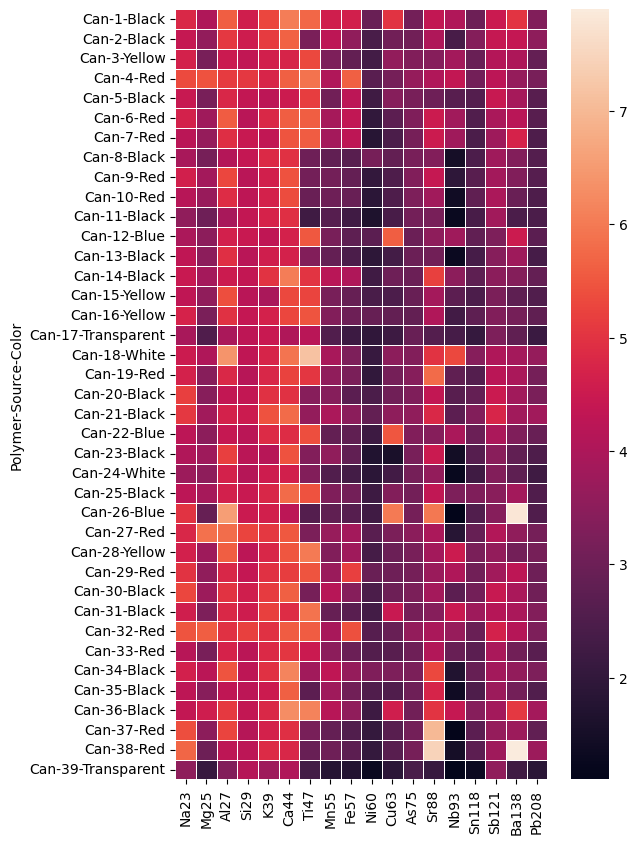

In [14]:
f, ax = plt.subplots(figsize=(6, 10))
sns.heatmap(np.log10(data_mean).replace([np.nan, -np.inf], 0), annot=False, linewidths=.4, ax=ax)

<Axes: >

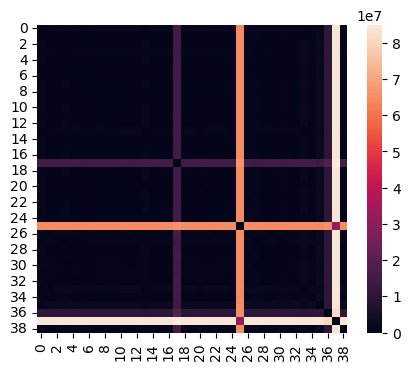

In [15]:
f, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(squareform(pdist(data_mean)))

### Barchart

In [16]:
stats = data_log.agg(['mean', 'std'])[sorted(data_x.columns, key=lambda x: int(re.search(r'\d+', x).group()))] # Sort columns on atomic mass
stats

,Na23,Mg25,Al27,Si29,K39,Ca44,Ti47,Mn55,Fe57,Ni60,Cu63,As75,Sr88,Nb93,Sn118,Sb121,Ba138,Pb208
mean,4.293841,3.606948,4.869217,4.369352,4.649493,5.217639,4.291795,3.260922,3.212902,2.249668,3.014199,3.068501,4.203609,2.265351,2.567094,3.697667,3.782869,2.776936
std,1.325436,0.924855,0.669569,0.299001,0.713559,0.585289,1.389691,1.324995,1.162140,0.459200,1.360959,0.350054,1.092742,2.201506,1.374370,0.488053,1.181356,0.544164


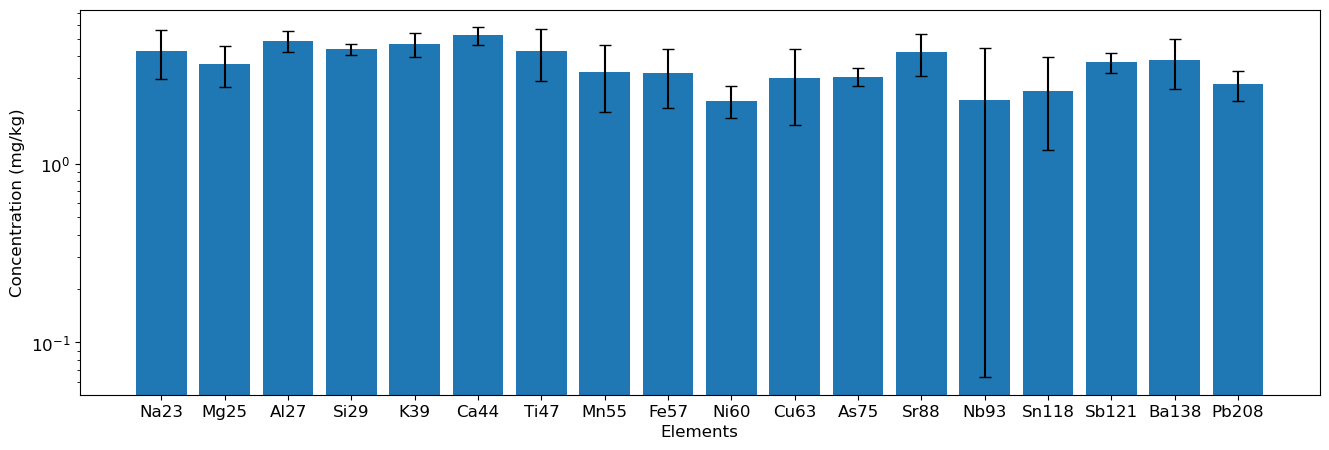

In [17]:
fig, ax = plt.subplots(figsize=(16,5))

ax.bar(stats.columns, stats.loc['mean'], yerr=stats.loc['std'], capsize=4)

plt.ylabel("Concentration (mg/kg)", fontsize = 12) #Counts ($\mathregular{s^{-1}}$)
plt.xlabel("Elements", fontsize = 12)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
ax.set_yscale('log')

#plt.gcf().subplots_adjust(bottom=0.4, left = 0.05)

#plt.savefig('img/Concentrations_tapes_PVC.svg') # Save image.

### Histograms

In [18]:
# print("Histogram of all measured concentrations:")
# data_x.hist(figsize=(20,10), layout=(4,6));

In [19]:
# print("Histogram of all measured concentrations:")
# data_log.hist(figsize=(20,10), layout=(4,6));

In [20]:
# print("Histograms of standard deviations within objects:")
# data_log.groupby('Source').std().hist(figsize=(20,10), layout=(4,6));

### Correlation

#### Between

<Axes: >

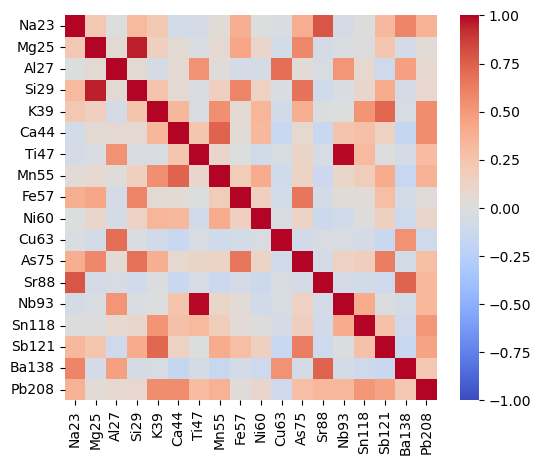

In [21]:
plt.figure(figsize=(6,5))
sns.heatmap(data_mean.corr(), cmap='coolwarm', vmin=-1)

<Axes: >

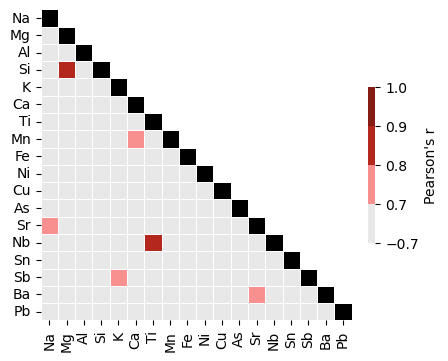

In [22]:
fig, ax = plt.subplots(figsize=(4.3,3.5), layout="constrained")

corr = data_mean.corr()

mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

colors = ["#E8E8E8", "#FF7373", "#C22A1E", "#851D15"]
cmap = LinearSegmentedColormap.from_list("Custom", colors, N=5)
cmap.set_over(color="black")

#labels=['Na', 'Mg', 'Al', 'Si', 'Ca', 'Ti', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Ga', 'As', 'Sr', 'Nb', 'Pd', 'Sn', 'Sb', 'Ba', 'Pb']

def func(x):
    if abs(x) < .7:
        return .6
    elif x == 1:
        return 1
    else:
        return x // .1 * .1

sns.heatmap(
    corr.applymap(func), 
    xticklabels=[re.sub('[0-9]', "", i) for i in corr.applymap(func).columns], 
    yticklabels=[re.sub('[0-9]', "", i) for i in corr.applymap(func).columns], 
    mask=mask, 
    cmap=cmap,
    vmin=.6,
    vmax=.99,
    linewidths=.5, 
    fmt='.3f',
    cbar_kws={"shrink": .5, "boundaries": [-.7, .7, .8, .9, 1], "label": "Pearson's r"}, 
    square=True)

#fig.savefig('img/Correlation-Tubing.svg') # Save image.

#### Within

In [23]:
#Select example
data_sample = data_x.loc[("Can", '1')][sorted(data_x.columns, key=lambda x: int(re.search(r'\d+', x).group()))]

<Axes: >

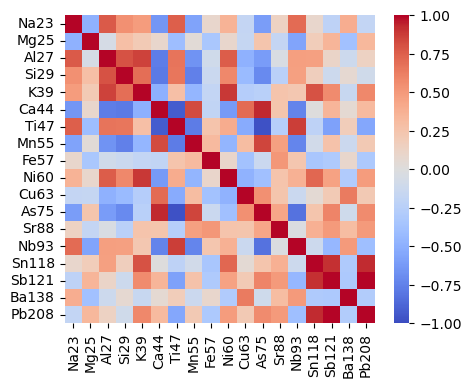

In [24]:
plt.figure(figsize=(5,4))
sns.heatmap(data_sample.corr(), cmap='coolwarm', vmin=-1)

#plt.savefig('img/Correlation-tubing_within02.svg') # Save image.

<Axes: >

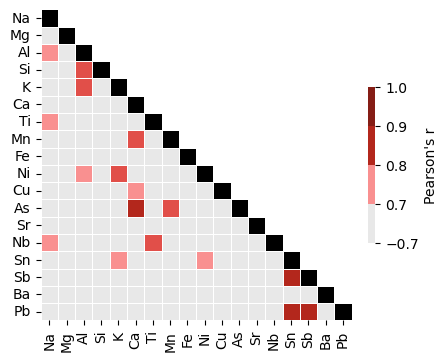

In [25]:
fig, ax = plt.subplots(figsize=(4.3,3.5), layout="constrained")

corr = data_sample.corr()

mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

colors = ["#E8E8E8", "#FF7373", "#C22A1E", "#851D15"]
cmap = LinearSegmentedColormap.from_list("Custom", colors, N=5)
cmap.set_over(color="black")

#labels=['C', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ti', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Ga', 'As', 'Sr', 'Nb', 'Pd', 'Sn', 'Sb', 'Ba', 'Pb']

#palette=["#E8E8E8", "#E7A3A0", "#F05E5E", "#C22A1E", "black"]

def func(x):
    if abs(x) < .7:
        return .6
    elif x == 1:
        return 1
    else:
        return x // .1 * .1

sns.heatmap(
    corr.applymap(func), 
    xticklabels=[re.sub('[0-9]', "", i) for i in corr.applymap(func).columns], 
    yticklabels=[re.sub('[0-9]', "", i) for i in corr.applymap(func).columns], 
    mask=mask, 
    cmap=cmap,
    vmin=.6,
    vmax=.99,
    linewidths=.5, 
#    annot=True,
    fmt='.3f',
    cbar_kws={"shrink": .5, "boundaries": [-.7, .7, .8, .9, 1], "label": "Pearson's r"}, 
    square=True)

#fig.savefig('img/Correlation-tubing.svg') # Save image.

### Pairplot

In [26]:
# sns.set_theme(style='ticks')
# sns.pairplot(data_log)

# #plt.savefig('img/Pairplot.svg') # Save image.

# plt.show()
# plt.close()

## Statistics

The following metrics are calculated:
* RSD within sample
* RSD within batch (only for tapes)
* Between run variation (over 2 weeks)
* RSD between source

### RSD within sample

In [27]:
within_sample_stdv = data_x.groupby(['Polymer', 'Source', 'Day2', 'Batch', "Color"]).agg('std')

In [28]:
within_sample_rsd = (within_sample_stdv/data_mean*100)
#within_sample_rsd.round(1)

In [29]:
within_sample_rsd.mean(axis=1).sort_values()

Polymer  Source  Color   Day2  Batch
Can      36      Black   2     A          7.642298
         1       Black   2     A          9.041452
         29      Red     2     A          9.291229
         36      Black   1     A          9.963467
         18      White   2     A         10.275297
                                           ...    
         3       Yellow  1     A         91.575549
         21      Black   1     A         96.768623
         20      Black   1     A         98.151584
         30      Black   1     A        111.021187
         20      Black   2     A        124.035009
Length: 78, dtype: float64

In [30]:
RSD_within_sample = within_sample_rsd.mean().sort_values()
RSD_within_sample

Ca44     12.109113
Si29     12.164588
Al27     19.366724
Sr88     21.948900
Mg25     22.360433
           ...    
Cu63     42.776461
Na23     50.875150
Pb208    58.604735
Nb93     61.711270
Sb121    76.875254
Length: 18, dtype: float64

In [31]:
RSD_within_sample_mean = RSD_within_sample.mean()
RSD_within_sample_mean

35.93477723660691

### Between run variation

In [32]:
data_day1 = data_x.reset_index().loc[data_x.reset_index()['Day2'] == 1].loc[data_x.reset_index()['Batch'].str.contains('A')].drop(columns=['Batch'])
data_day2 = data_x.reset_index().loc[data_x.reset_index()['Day2'] == 2].loc[data_x.reset_index()['Batch'].str.contains('A')].drop(columns=['Batch'])

In [33]:
data_day1_mean = data_day1.groupby(['Polymer', 'Source','Color']).agg('mean').drop(columns=['Day2','N'])
data_day2_mean = data_day2.groupby(['Polymer', 'Source','Color']).agg('mean').drop(columns=['Day2','N'])

In [34]:
#Only for Tapes normalized by SRM glass standard
# data_day2_mean = data_day2_mean.drop(index=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23',
#                            '24','25','26','27','28','29','30','31','32','33','34','35','36','37','38','39','40','41','42','43','44','45','46','47',
#                            '48','49','50','51','52','83','84','85','86','87'], level=1)
#Only for SRM Wires
# data_day1_mean = data_day1_mean.drop(index=['01','02','03','04','05','06','07','45'], level=1)

In [35]:
change = ((data_day2_mean - data_day1_mean)/data_day1_mean *100)
change

Na23        Mg25        Al27        Si29  \
Polymer Source Color                                                         
Can     1      Black         30.837542   -5.855405   39.817332    9.126368   
        2      Black        138.250655   35.998587   98.853939    5.708484   
        3      Yellow       -66.397312  -26.120281   68.036104   80.902270   
        4      Red            7.647882   81.618084   84.315262   62.803862   
        5      Black         36.758747   31.891062   48.752360   48.589859   
...                                ...         ...         ...         ...   
        35     Black        613.534908   44.872501   39.713111   29.700383   
        36     Black        -29.140838   27.133243   10.950590   20.460065   
        37     Red           -2.531811    7.095812    1.405550   19.774921   
        38     Red           10.828840   -5.085509  -11.881312   27.028470   
        39     Transparent  466.069871  311.099245  365.091075  466.025686   

                                   K39        Ca44        Ti47        Mn55  \
Polymer Source Color                                                         
Can     1      Black         19.863629  -13.642391   14.641571  -37.988895   
        2      Black         69.622590   41.321630    7.076672  -12.151611   
        3      Yellow       166.741370  160.476339  193.946631   94.230435   
        4      Red           44.483719   68.771630   85.799895   70.464266   
        5      Black         41.820639   30.795097   59.153611    9.428720   
...                                ...         ...         ...         ...   
        35     Black        166.062444   43.208225   47.730234   36.718210   
        36     Black        -44.506442   34.055631   17.954708   19.910762   
        37     Red           70.821740    3.501846   46.466982  -14.667823   
        38     Red          -17.947219   16.058086  146.956683  -22.136623   
        39     Transparent  121.209198  450.414489  456.344962  221.361214   

                                  Fe57        Ni60        Cu63       As75  \
Polymer Source Color                                                        
Can     1      Black          2.796467    5.368297   -4.194667 -80.792452   
        2      Black         31.546893    6.650669  -42.209042 -71.804383   
        3      Yellow       -47.580707  178.911119  -95.003035 -76.640309   
        4      Red          103.764362   68.682217  -54.988628   8.180923   
        5      Black        -15.290976  -26.710915   29.786150 -73.642384   
...                                ...         ...         ...        ...   
        35     Black         30.133681  290.520867  232.332227 -23.082290   
        36     Black         42.339220   -3.678461   12.821689 -14.105506   
        37     Red           71.696602   81.710828   33.048314 -27.450209   
        38     Red            0.782333  -10.202946   40.801490 -16.484597   
        39     Transparent   77.039207  211.014360  117.694886  29.186286   

                                  Sr88        Nb93       Sn118        Sb121  \
Polymer Source Color                                                          
Can     1      Black        -16.056064    9.994897   -7.161261   -96.701797   
        2      Black         44.416651  -87.868295   -1.441496   107.960431   
        3      Yellow        30.544616  154.747602  108.724097   -56.770497   
        4      Red           47.145280   65.139056  127.330035   -42.028472   
        5      Black          7.933479   27.256086   -0.532840    -1.841019   
...                                ...         ...         ...          ...   
        35     Black         38.292639   38.171875  253.005372   -42.490785   
        36     Black         19.341887    8.479722    8.039015   -50.806392   
        37     Red           -3.746448  -43.443050  -11.816031   -28.441945   
        38     Red           19.153122   75.930435    4.578818    41.845107   
        39     Transparent  229.543941  -38.663388  -9

In [36]:
change.mean(axis=1).sort_values() #> 1e10 #1-27 has a difference larger than 1e10

Polymer  Source  Color      
Can      30      Black          -40.259569
         29      Red            -30.071275
         32      Red            -22.220588
         19      Red            -16.630609
         34      Black          -15.184753
                                   ...    
         20      Black          129.339564
         21      Black          132.266921
         23      Black          291.200937
         39      Transparent    458.014184
         17      Transparent    817.669930
Length: 39, dtype: float64

In [37]:
change.mean().sort_values()

As75     -57.592228
Ba138     31.927573
Pb208     35.271860
Mn55      38.946470
Sn118     39.902047
            ...    
Al27      76.078293
Na23     129.688454
Cu63     166.750265
Nb93     172.997633
Ti47     193.029056
Length: 18, dtype: float64

In [38]:
Between_run_variation_mean = abs(change.mean()).mean()
Between_run_variation_mean

79.1278371022073

### RSD between source

The average value of two days and multiple batches (if applicable) was used.

In [39]:
between_source_stdv = data_mean.std()

In [40]:
RSD_between_source = (between_source_stdv/data_mean.mean())*100
RSD_between_source

Na23     144.792326
Mg25     336.316418
Al27     251.002039
Si29     113.483584
K39       75.662011
            ...    
Nb93     330.062554
Sn118    110.936822
Sb121    106.204529
Ba138    436.455843
Pb208    126.994711
Length: 18, dtype: float64

In [41]:
RSD_between_source_mean = RSD_between_source.mean()
RSD_between_source_mean

222.16996660005057

### Ratio between/within

In [42]:
ratio = RSD_between_source/RSD_within_sample
ratio.sort_values()

As75      1.357070
Sb121     1.381518
Pb208     2.166970
K39       2.366445
Na23      2.846032
           ...    
Ti47     12.432174
Fe57     12.530351
Al27     12.960480
Mg25     15.040694
Sr88     20.716016
Length: 18, dtype: float64

In [43]:
Ratio_mean = ratio.mean()
Ratio_mean

7.743423531232232

## Profiling

### Clustermap

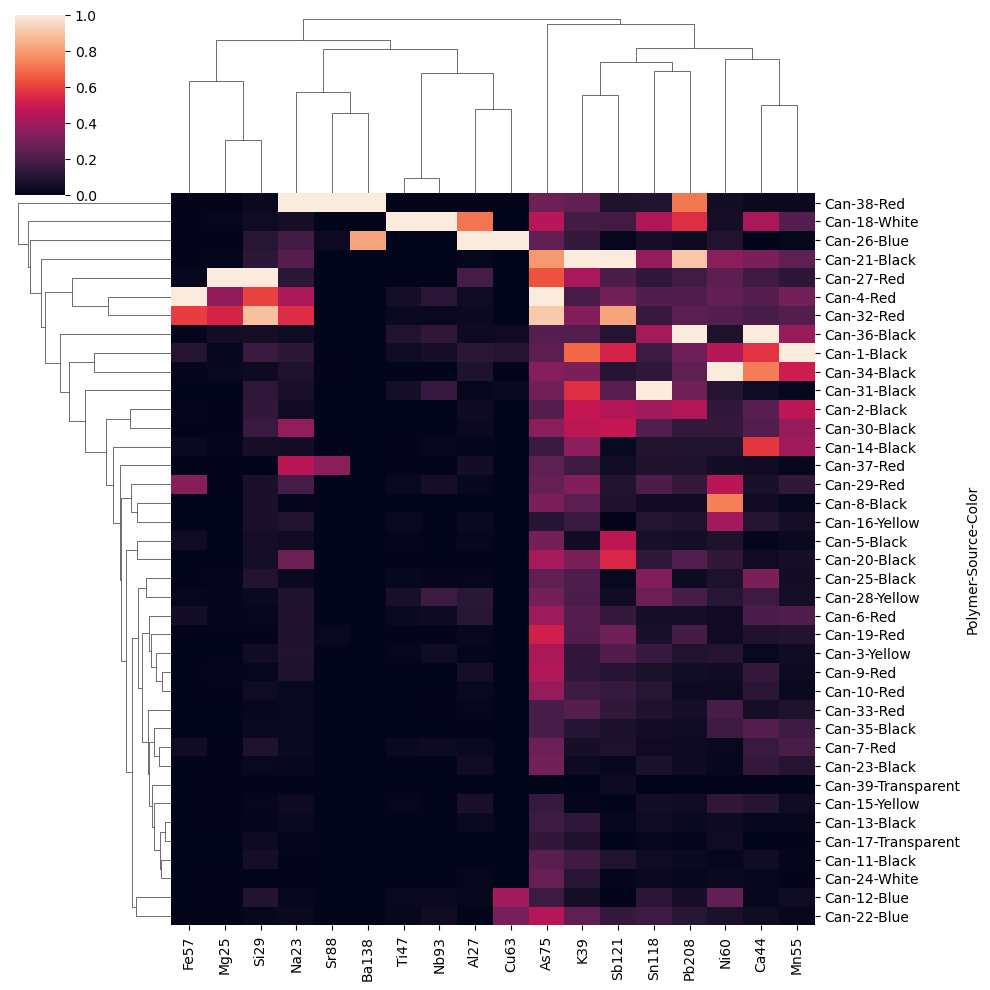

In [44]:
sns.clustermap(data_mean, standard_scale=True)

### PCA

#### Effect of preprocessing

In [45]:
pca = PCA()

class NoOpTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X
    
p = Pipeline([('scaler', NoOpTransformer()), ('pca', pca)])
p['pca']

PCA()

In [46]:
results = dict(
    no_preprocessing = Pipeline([('scaler', NoOpTransformer()), ('pca', pca)]),
    StandardScaler   = Pipeline([('scaler', StandardScaler()), ('pca', pca)]),
    RobustScaler   = Pipeline([('scaler', RobustScaler()), ('pca', pca)]),
    MinMaxScaler   = Pipeline([('scaler', MinMaxScaler()), ('pca', pca)]),
    MaxAbsScaler   = Pipeline([('scaler', MaxAbsScaler()), ('pca', pca)]),
    QuantileTransformer   = Pipeline([('scaler', QuantileTransformer(n_quantiles=10)), ('pca', pca)]),
    Normalizer   = Pipeline([('scaler', Normalizer()), ('pca', pca)]))

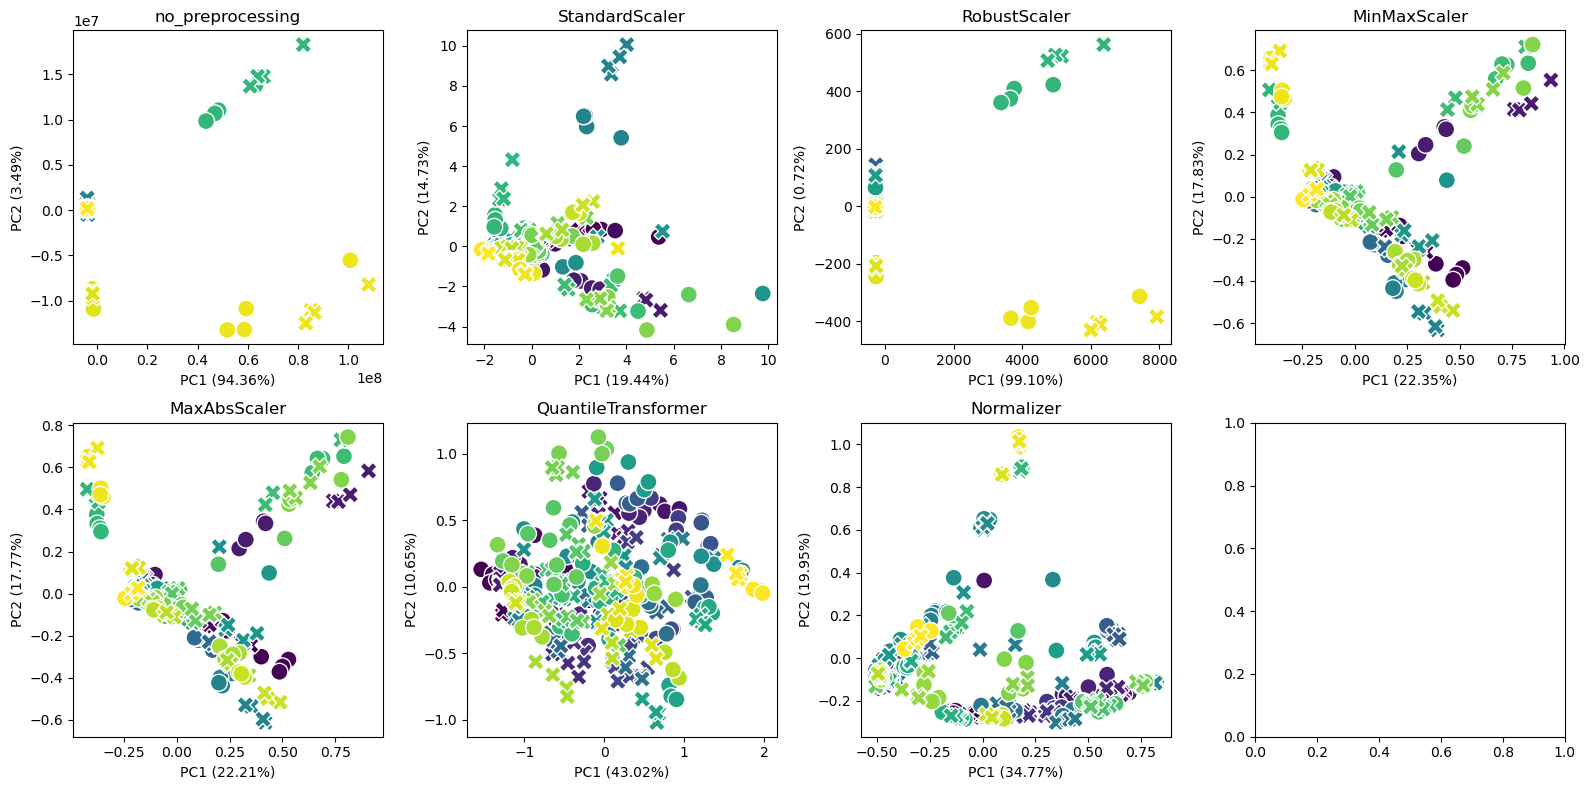

In [47]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,8), layout="tight")
for (label, result), ax in zip(results.items(), axs.flatten()):
    model = result.fit(data_x)
    data = pd.DataFrame(model.transform(data_x), index=data_x.index).reset_index()
    sns.scatterplot(data=data, x=0, y=1, hue='Source', style="Day2",palette="viridis", s=150, legend=False, ax=ax)
    ax.set(title=label, xlabel=f"PC1 ({model['pca'].explained_variance_ratio_[0]:.2%})", ylabel=f"PC2 ({model['pca'].explained_variance_ratio_[1]:.2%})")

#### Normalization

In [48]:
cps_norm = pd.DataFrame(QuantileTransformer(n_quantiles=10).fit_transform(data_x), index=data_x.index)

In [49]:
pca = PCA()
pca_data = pd.DataFrame(
    pca.fit_transform(cps_norm), 
    index=data_x.index,
    columns=np.arange(1, cps_norm.shape[1]+1))

#### Leave one out validation

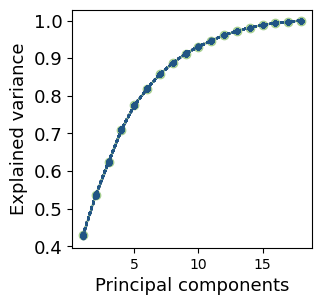

In [50]:
plt.figure(figsize=(4, 3.5))
#plt.figure(figsize=(2.4, 2))

#Leave one out validation
plt.plot(pd.Series(np.cumsum(pca.explained_variance_ratio_), index=np.arange(1, len(pca.explained_variance_ratio_)+1)), marker='o', color='#A5CD90')

for leaveout in cps_norm.index:
    pca = pca.fit(cps_norm.drop(leaveout))
    plt.plot(pd.Series(np.cumsum(pca.explained_variance_ratio_), index=np.arange(1, len(pca.explained_variance_ratio_)+1)), alpha=.4, ls=':', marker='.', color='#215584')
    
plt.xlabel("Principal components", fontsize = 13)
plt.ylabel("Explained variance", fontsize = 13)
# plt.xticks(np.arange(0, 21, step=5),fontsize=13)
# plt.yticks(np.arange(0.6, 1.1, step=0.1),fontsize=13)
#plt.xticks(np.arange(2, 5, step=1),fontsize=13)
#plt.yticks(np.arange(0.7, 0.9, step=0.05),fontsize=13)
#plt.xlim(2.9, 4.1)
#plt.ylim(0.8, 0.86)
plt.yticks(fontsize=13)
plt.gcf().subplots_adjust(bottom=0.2, left = 0.3)

#plt.xaxis.set_minor_locator(MultipleLocator(1))

#plt.savefig('img/Dimenstions_zoom.svg') # Save image.

#### Score plot

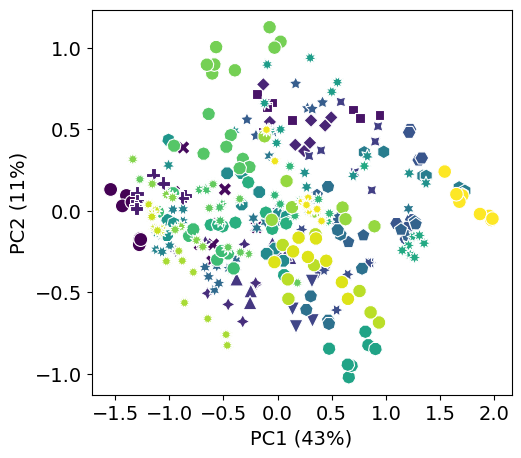

In [51]:
plt.figure(figsize=(6,5))

sns.scatterplot(data=pca_data.reset_index(), x=1, y=2, hue='Source', style="Source", s=100, palette="viridis", legend=False)
plt.xlabel(f'PC1 ({round(pca.explained_variance_ratio_[0],2):.0%})', fontsize = 14)
plt.ylabel(f'PC2 ({round(pca.explained_variance_ratio_[1],2):.0%})', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.gcf().subplots_adjust(left=0.2)

#plt.savefig('img/PCA_Tapes_Black.svg') # Save image.

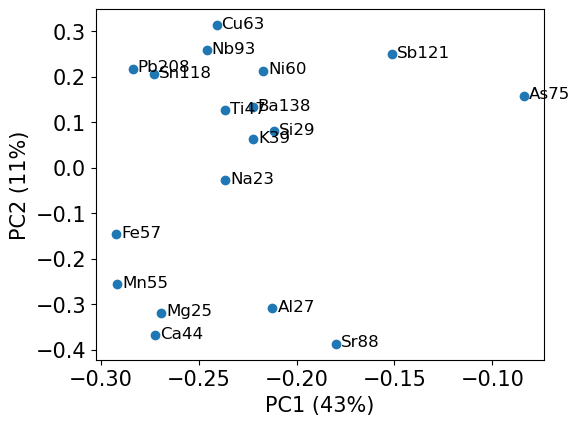

In [52]:
loadings = pd.DataFrame(pca.components_, columns=data_x.columns).T[[0, 1]]

plt.scatter(loadings[0], loadings[1])
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.0%})', fontsize = 15)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.0%})', fontsize = 15)
for label, x, y in loadings.itertuples():
#    if y>0.1: #or x>0.1
       plt.annotate(label, (x, y), xytext=(5, -3), textcoords=('offset pixels', 'offset pixels'), fontsize=12)


plt.xticks(fontsize=15)
plt.yticks(fontsize=15) #(np.arange(-0.6,0.8, step=0.2), fontsize=15)
plt.gcf().subplots_adjust(left=0.15, bottom=0.15)

plt.gcf().subplots_adjust(left=0.2)

#plt.savefig('img/PCA_loadings.svg') # Save image.

### LDA

In [53]:
clf = LinearDiscriminantAnalysis()
clf.fit(X=data_x, y=data_x.index.get_level_values('Source')) #cps_wire, cps_wire_IS, etc.

lda = pd.DataFrame(clf.transform(data_x)[:,0:2], index=data_x.index)
lda

0         1
Polymer Source Day2 Batch Color       N                    
Can     1      1    A     Black       1  2.647244 -3.180250
                                      2  2.821192 -3.459253
                                      3  2.431143 -3.451248
                                      4  2.609902 -3.534992
               2    A     Black       1  2.435162 -2.453036
...                                           ...       ...
        39     1    A     Transparent 4  2.121994  2.277525
               2    A     Transparent 1  2.173560  2.321417
                                      2  2.230223  2.595305
                                      3  2.234892  2.674773
                                      4  2.238862  2.654955

[312 rows x 2 columns]

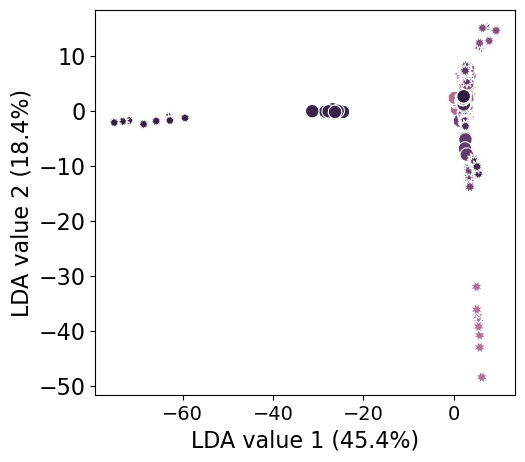

In [54]:
plt.figure(figsize=(6, 5))

#sns.scatterplot(x=lda[0], y=np.ones(len(lda)), hue=cps_wire.index.get_level_values('Sample'))
sns.scatterplot(x=lda[0], y=lda[1], hue=data_x.index.get_level_values('Source'), style=data_x.index.get_level_values('Source'), s=100, legend=False)
plt.xlabel(f'LDA value 1 ({clf.explained_variance_ratio_[0]:.01%})', fontsize = 16)
plt.ylabel(f'LDA value 2 ({clf.explained_variance_ratio_[1]:.01%})', fontsize = 16)
plt.xticks(fontsize = 14)
#plt.xlim(-7,2)
plt.yticks(fontsize = 16)
#plt.legend(fontsize=16)

plt.gcf().subplots_adjust(left=0.2)

#plt.xlim(-90, -40)

#plt.savefig('img/LDA_PVC_tapes_black.svg') # Save image.

In [55]:
loadings_lda = pd.DataFrame(clf.scalings_.T[0:2], columns=data_x.columns).loc[0:1]

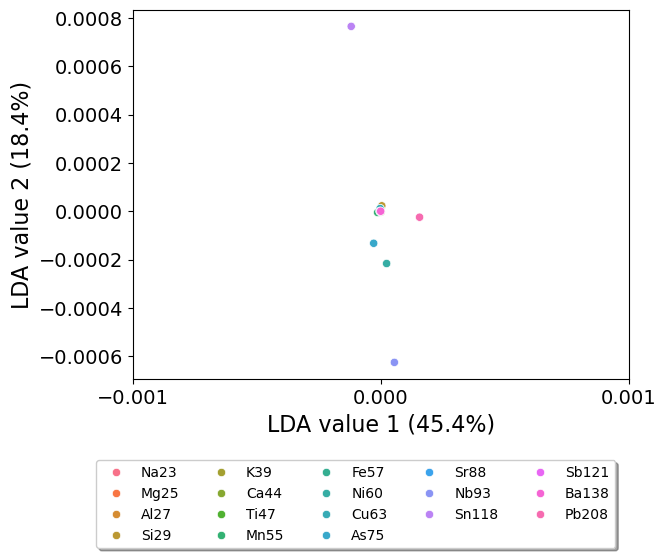

In [56]:
sns.scatterplot(data=loadings_lda.T.reset_index(), x=0, y=1, hue='index')
plt.xlabel(f'LDA value 1 ({clf.explained_variance_ratio_[0]:.01%})', fontsize = 16)
plt.ylabel(f'LDA value 2 ({clf.explained_variance_ratio_[1]:.01%})', fontsize = 16)

for label, x, y in loadings_lda.T.itertuples():
    if x>0.0005 or x<-0.0005: #y>5e4:
       plt.annotate(
           text=label, 
           xy=(x, y), 
           xytext=(5, -3), 
           textcoords=('offset pixels', 'offset pixels'),
       )

plt.xticks(np.arange(-0.001, 0.002, step=0.001), fontsize=14)
plt.yticks(fontsize = 14)
    
plt.legend(loc='upper center', bbox_to_anchor=(0.45, -0.2),
          fancybox=True, shadow=True, ncol=5)

#plt.savefig('img/LDA_loadings_tube.svg') # Save image.

### t-SNE

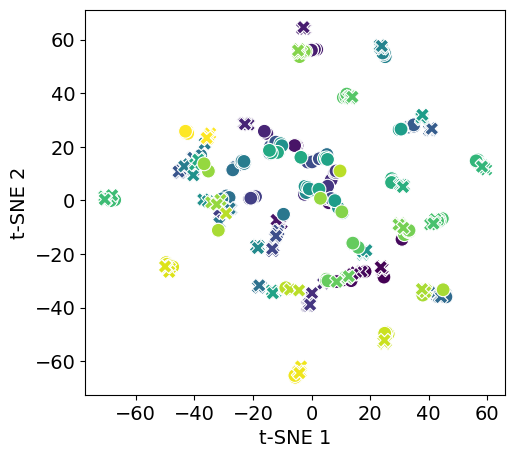

In [57]:
fig, ax = plt.subplots(figsize=(6,5))
scaler = StandardScaler()
embedding = TSNE(init='random', perplexity=5, random_state=6).fit_transform(scaler.fit_transform(data_x))
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=data_x.index.get_level_values('Source'), style=data_x.index.get_level_values('Day2'), ax=ax, s=100, palette="viridis", legend=False)

plt.xlabel('t-SNE 1', fontsize = 14)
plt.ylabel('t-SNE 2', fontsize = 14)
plt.xticks(fontsize = 14)
#plt.xlim(-7,2)
plt.yticks(fontsize = 14)

plt.gcf().subplots_adjust(left=0.2)

#plt.savefig('img/tSNE_tapes_PVC_Black.svg') # Save image.

## Comparison models

Log transformed data was used. Only one batch was considered to equalize the number of repetitions

### 4s match criterion

#### Same-source comparison

In [58]:
# Taking into account that if the Known stdv is less than 3% of the mean, then 3% of the mean is used in place of stdv.
data_4s_same = (((dataset1_mean/((dataset2_mean - dataset1_mean).abs())) * ((dataset1_std/dataset1_mean).abs().clip(lower=0.03)))).abs() < 1/4
data_4s_same

Al27   As75  Ba138   Ca44   Cu63   Fe57    K39   Mg25   Mn55  \
Polymer Source                                                                  
Can     1       False  False  False  False  False  False  False  False  False   
        2       False  False  False  False  False  False  False  False  False   
        3       False  False  False  False  False  False  False  False  False   
        4       False  False  False  False  False  False  False  False  False   
        5       False  False  False  False  False  False  False  False  False   
...               ...    ...    ...    ...    ...    ...    ...    ...    ...   
        35      False  False  False  False  False  False  False  False  False   
        36      False  False  False  False  False  False  False  False  False   
        37      False  False  False  False  False  False  False  False  False   
        38      False  False  False  False  False  False  False  False  False   
        39      False  False  False  False  False  False   True  False   True   

                 Na23   Nb93   Ni60  Pb208  Sb121   Si29  Sn118   Sr88   Ti47  
Polymer Source                                                                 
Can     1       False  False  False  False  False  False  False  False  False  
        2       False  False  False  False  False  False  False  False  False  
        3       False  False  False  False  False  False  False  False   True  
        4       False  False  False  False  False  False  False  False  False  
        5       False  False  False  False  False  False  False  False  False  
...               ...    ...    ...    ...    ...    ...    ...    ...    ...  
        35      False  False  False  False  False  False   True  False  False  
        36      False  False  False  False  False  False  False  False  False  
        37      False  False  False  False  False  False  False  False  False  
        38      False   True  False  False  False  False  False  False  False  
        39      False   True  False  False  False  False  False  False  False  

[39 rows x 18 columns]

In [59]:
#True: different source, False: same source
#Low number of 'True' (false exclusion) results are desired.
# data_4s_same = ((dataset2_mean - dataset1_mean).abs() / dataset1_std) > 4
# data_4s_same

In [60]:
#Percentage of false exclusion (no match if already one 'mismatched' element counts (if True in table)
False_exclusion_4s_percentage = data_4s_same.any(axis=1).mean()
False_exclusion_4s_percentage*100

20.51282051282051

In [61]:
False_exclusion_4s_samples = False_exclusion_4s_percentage*sample_size_same
False_exclusion_4s_samples

8.0

In [62]:
#Percentage of elements that do not match
False_exclusion_total_4s_percentage = np.mean(data_4s_same) #data_T_4s_different.xs('02', level=1,axis=0, drop_level=True)
False_exclusion_total_4s_percentage*100

1.4245014245014245

In [63]:
N_elements_false_exclusion_4s = False_exclusion_total_4s_percentage*dataset_size_same
N_elements_false_exclusion_4s

10.0

#### Different-source comparison

(n*p*(n*p-p)) or n*(n-1) or To estimate the
false inclusion rate, different-source comparisons (known to originate
from different glass panes) were generated by comparing the four random
replicates of a sample to 4 random replicates of a different sample

In [64]:
#True: same source, False: different source
#Low number of 'True' (false inclusion) results are desired.
result = {}
for source in dataset2_mean.index:
#    A = (abs(dataset2_mean.drop(index=[source]) - dataset1_mean.loc[source])/dataset1_std.loc[source]) < 4 If not considering minimum of mean/std of 0.03.
    A = (abs(dataset1_mean.loc[source]/(dataset2_mean.drop(index=[source]) - dataset1_mean.loc[source]))*(abs(dataset1_std.loc[source]/dataset1_mean.loc[source]).clip(lower=0.03))) > 1/4
    result[source] = A  

data_4s_different = pd.concat(result)
data_4s_different

Al27   As75  Ba138   Ca44   Cu63   Fe57    K39   Mg25  \
       Polymer Source                                                           
Can 1  Can     2        True   True  False   True  False  False   True  False   
               3       False   True  False  False  False  False  False  False   
               4        True   True  False   True  False  False   True  False   
               5       False   True  False  False  False   True  False  False   
               6        True   True  False   True  False   True  False   True   
...                      ...    ...    ...    ...    ...    ...    ...    ...   
    39 Can     34      False  False   True  False  False   True   True   True   
               35       True  False   True   True   True   True   True   True   
               36      False  False  False  False  False   True   True  False   
               37      False  False   True   True   True   True   True   True   
               38       True  False  False   True   True   True   True   True   

                        Mn55   Na23   Nb93   Ni60  Pb208  Sb121  Si29  Sn118  \
       Polymer Source                                                          
Can 1  Can     2        True   True  False  False   True   True  True   True   
               3       False   True  False  False   True   True  True   True   
               4        True  False   True   True   True   True  True   True   
               5       False   True  False  False   True   True  True   True   
               6       False   True   True  False   True   True  True   True   
...                      ...    ...    ...    ...    ...    ...   ...    ...   
    39 Can     34      False   True  False  False   True   True  True   True   
               35      False   True   True  False   True   True  True   True   
               36      False   True  False  False   True   True  True   True   
               37      False   True   True   True   True   True  True   True   
               38      False   True  False   True   True   True  True   True   

                        Sr88   Ti47  
       Polymer Source                
Can 1  Can     2        True  False  
               3       False  False  
               4        True   True  
               5       False   True  
               6        True   True  
...                      ...    ...  
    39 Can     34      False   True  
               35      False   True  
               36      False  False  
               37      False   True  
               38      False   True  

[1482 rows x 18 columns]

In [65]:
#Percentage of false inclusion (only if all elements match)
False_inclusion_4s_percentage = data_4s_different.all(axis=1).mean() #comparison 1-2 and 2-1 is in result
False_inclusion_4s_percentage*100

2.0242914979757085

In [66]:
False_inclusion_4s_samples = False_inclusion_4s_percentage*sample_size_different*2
False_inclusion_4s_samples

30.0

In [67]:
#Percentage of elements that do not match
False_inclusion_total_4s_percentage = np.mean(data_4s_different)
False_inclusion_total_4s_percentage*100

63.34532913480282

In [68]:
N_elements_false_inclusion_4s = False_inclusion_total_4s_percentage*dataset_size_different*2 #comparison 1-2 and 2-1 is in result
N_elements_false_inclusion_4s

16898.0

### t-test match criterion

#### Same-source comparison

In [69]:
results = list()
for source in sources:
    for atom in atoms:
        data_day1 = dataset1.xs(source, level="Source")[atom].to_list()
        data_day2 = dataset2.xs(source, level="Source")[atom].to_list()
        #If equal_var=False, perform Welch’s t-test, which does not assume equal population variance 
        #If equal_var=True (default), perform a standard independent 2 sample test that assumes equal population variances. 
        result = ttest_ind(data_day1, data_day2, equal_var=False) 
        results.append((source, atom, result.pvalue))

C:\Users\mirja\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [70]:
#False discovery control
#false_discovery_control(pd.DataFrame(results, columns=["source", "atom", "pvalue"]).pivot_table(index="source", columns="atom", values="pvalue").loc["11"])

In [71]:
#p-value normally < 0.05, but Bonferroni correction to compensate for multiple comparisons problem
data_ttest_same = pd.DataFrame(results, columns=["source", "atom", "pvalue"]).pivot_table(index="source", columns="atom", values="pvalue") < 0.00263157894
data_ttest_same

atom,Al27,As75,Ba138,Ca44,Cu63,Fe57,K39,Mg25,Mn55,Na23,Nb93,Ni60,Pb208,Sb121,Si29,Sn118,Sr88,Ti47
source,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
36,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
37,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [72]:
#Percentage of false exclusion (no match if already one 'mismatched' element counts (if True in table)
False_exclusion_ttest_percentage = data_ttest_same.any(axis=1).mean()
False_exclusion_ttest_percentage*100

2.564102564102564

In [73]:
False_exclusion_ttest_samples = False_exclusion_ttest_percentage*sample_size_same
False_exclusion_ttest_samples

1.0

In [74]:
#Percentage of elements that do not match
False_exclusion_total_ttest_percentage = np.mean(data_ttest_same) #data_T_4s_different.xs('02', level=1,axis=0, drop_level=True)
False_exclusion_total_ttest_percentage*100

0.14245014245014245

In [75]:
N_elements_false_exclusion_ttest = False_exclusion_total_ttest_percentage*dataset_size_same
N_elements_false_exclusion_ttest

1.0

#### Different-source comparison

In [76]:
results = list()
for source in tqdm(background_all.index.get_level_values("Source").unique()):
    first_day_source = background_all.xs(source, level="Source").groupby("N").first()
    second_day_other_source = background_all.drop(index=source, level="Source").groupby(["Source", "N"]).last()
    for other_source in second_day_other_source.index.get_level_values("Source").unique():
        for element in first_day_source.columns:
            arr1 = first_day_source[element].values
            arr2 = second_day_other_source.xs(other_source, level="Source")[element].values
            results.append((source, other_source, element, ttest_ind(arr1, arr2, equal_var=False).pvalue))        

  0%|          | 0/39 [00:00<?, ?it/s]

C:\Users\mirja\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\mirja\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\mirja\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\mirja\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurre

In [77]:
data_ttest_different = (
    pd.DataFrame(results, columns=["Source", "Other source", "Element", "pvalue"]).pivot(index=["Source", "Other source"], columns="Element") > 0.00263157894
)
data_ttest_different

pvalue                                                   \
Element               Al27   As75  Ba138   Ca44   Cu63   Fe57    K39   Mg25   
Source Other source                                                           
1      2              True   True  False  False  False  False   True  False   
       3             False  False  False  False  False  False   True  False   
       4              True   True  False  False  False  False   True  False   
       5             False   True  False  False  False  False  False  False   
       6              True   True  False  False  False   True   True   True   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
39     34            False  False   True  False   True   True   True   True   
       35            False  False   True  False   True   True   True   True   
       36            False  False  False  False  False   True   True   True   
       37            False  False   True  False   True   True   True   True   
       38             True  False  False  False   True   True   True   True   

                                                                            \
Element               Mn55   Na23   Nb93   Ni60  Pb208  Sb121   Si29 Sn118   
Source Other source                                                          
1      2             False   True  False   True   True   True   True  True   
       3             False   True   True  False   True   True  False  True   
       4             False  False  False  False   True   True  False  True   
       5             False   True  False  False   True   True  False  True   
       6             False   True  False  False   True   True  False  True   
...                    ...    ...    ...    ...    ...    ...    ...   ...   
39     34             True   True   True  False  False  False  False  True   
       35             True   True   True  False  False  False  False  True   
       36             True   True  False  False  False  False  False  True   
       37             True   True   True  False   True  False  False  True   
       38             True   True   True  False   True  False  False  True   

                                   
Element               Sr88   Ti47  
Source Other source                
1      2              True  False  
       3             False  False  
       4              True  False  
       5             False  False  
       6              True   True  
...                    ...    ...  
39     34            False  False  
       35            False  False  
       36            False  False  
       37            False  False  
       38            False   True  

[1482 rows x 18 columns]

In [78]:
#data_ttest_different.mean().sort_values()

In [79]:
#Percentage of false inclusion (only if all elements match)
False_inclusion_ttest_percentage = data_ttest_different.all(axis=1).mean() #comparison 1-2 and 2-1 should be same in result, but is not always the case since first repetitions can differ from last repetions.
False_inclusion_ttest_percentage*100

1.349527665317139

In [80]:
False_inclusion_ttest_samples = False_inclusion_ttest_percentage*sample_size_different*2
False_inclusion_ttest_samples

20.0

In [81]:
#Percentage of elements that do not match
False_inclusion_total_ttest_percentage = np.mean(data_ttest_different)
False_inclusion_total_ttest_percentage*100

53.74493927125506

In [82]:
N_elements_false_inclusion_ttest = False_inclusion_total_ttest_percentage*dataset_size_different*2 #comparison 1-2 and 2-1 should be same in result, but is not always the case since first repetitions can differ from last repetions.
N_elements_false_inclusion_ttest

14337.000000000002

### Feature-based model (MVK)

The formulas and formulation described by Zadora 'Statistical Analysis in Forensic Science' (2014) were used.
* Background data: Source 1-87 (m=87), n=2
* Control:         Source n, day 1
* Recovered:       Source n, day 2

This calculation was not used for the final feature-based results in the manuscript of de Bruin-Hoegee et al. 'Evaluating the strength of evidence of elemental profiling of polymers with LA-ICP-MS', because a validated LR was obtained by using the script described by Corzo et al. in 'The use of LA-ICP-MS databases to calculate likelihood ratios for the forensic
analysis of glass evidence'.

#### Same-source comparison

In [83]:
#Only for wires
# background_all = background_all.drop(index=['01','02','03','04','05','06','07','45'], level=0)

In [84]:
background_all = background_all.reset_index().drop(columns=['Polymer']).set_index(['Source','Day2','N'])

result = {}
for selected_source in tqdm(background_all.reset_index()["Source"].unique()):
    #Variables
    background = background_all.drop([selected_source,], level=0, axis=0)
    background_mean = background.groupby(['Source']).agg('mean')

    # Control
    control_recovered = background_all.loc[(selected_source)].sort_values("N").reset_index() #same source
    control = (
        control_recovered
        .loc[control_recovered['N'].isin([1, 2])]
        .assign(Source=selected_source, N=[1,2,3,4])
        .drop(columns=['Day2'])
        .pivot_table(index=['Source','N']))
    control_mean    = control.groupby(["Source"]).agg('mean')

    # Recovered
    recovered = (
        control_recovered
        .loc[control_recovered['N'].isin([3, 4])]
        .assign(Source=selected_source, N=[1,2,3,4])
        .drop(columns=['Day2'])
        .pivot_table(index=['Source','N']))
    recovered_mean    = recovered.groupby(["Source"]).agg('mean')

    # Covariances
    cov_within_all = background.groupby(['Source']).agg('cov')
    cov_within = cov_within_all.reset_index().drop(columns=['Source']).groupby('level_1').agg('mean')
    cov_between = background_mean.cov()

    n      = 8  #number of repetitions background
    n1     = len(control)  #number of repetitions control
    n2     = len(recovered)  #number of repetitions recovered
    m      = len(background)/n  #number of sources

    U_df = cov_within
    U    = np.matrix(U_df)
    C_df = cov_between
    C    = np.matrix(C_df)

    P    = len(background.columns)
    H    : float = np.power((4/(m*((2*P)+1))),(1/(P+4)))  #smoothing parameter calculated as proposed in Aitken and Lucy (2004), dependent on number of features and sources.

    Y1_float      : float     = control_mean.values[0]  #mean control
    Y1                        = np.transpose(np.matrix(Y1_float))
    Y2_float      : float     = recovered_mean.values[0]  #mean recovered
    Y2                        = np.transpose(np.matrix(Y2_float))
    Y_star                    = (n1*Y1+n2*Y2)/(n1+n2) #weighted mean

    X_source: pd.Series = background_mean #mean background 
    assert m == len(X_source)

    #Numerator: multivariate data
    AA = (2*np.pi)**-(P/2)*np.sqrt(np.linalg.det(U/n1+U/n2))**-1
    BB = -0.5*np.transpose(Y1-Y2)*(U/n1+U/n2)**-1
    CC = (Y1-Y2)
    DD = (2*np.pi)**(-P/2)*np.sqrt(np.linalg.det(U/(n1+n2)+C*H**2))**-1

    _result = 0
    for Source in X_source.index:  
        EE = -0.5*np.transpose(Y_star - np.transpose(np.matrix(X_source.loc[Source]))) * (U/(n1+n2)+(H**2)*C)**-1 * (Y_star - np.transpose(np.matrix(X_source.loc[Source])))
        _result += np.exp(EE)

    NUM = AA*np.ndarray.item(np.exp(BB*CC))*(m**-1)*DD*np.ndarray.item(_result)

    #Denominator: multivariate data
    DEN = 0
    for Source in X_source.index:
        FF = ((2*np.pi)**(-P/2)*np.sqrt(np.linalg.det(U/n1+C*H**2))**-1)*m**-1 
        GG = ((2*np.pi)**(-P/2)*np.sqrt(np.linalg.det(U/n2+C*H**2))**-1)*m**-1 
        HH = -0.5*np.transpose(Y1 - np.transpose(np.matrix(X_source.loc[Source]))) * (U/n1+C*H**2)**-1 * (Y1 - np.transpose(np.matrix(X_source.loc[Source])))
        II = -0.5*np.transpose(Y2 - np.transpose(np.matrix(X_source.loc[Source]))) * (U/n2+C*H**2)**-1 * (Y2 - np.transpose(np.matrix(X_source.loc[Source])))
        DEN += FF * np.ndarray.item(np.exp(HH)) * GG * np.ndarray.item(np.exp(II))

    #Result LR
    LR = NUM/DEN
    result[selected_source] = LR
result = pd.Series(result)

  0%|          | 0/39 [00:00<?, ?it/s]

In [85]:
result.sort_values()

39    0.000000e+00
23    1.949497e-21
20    9.418923e-17
3     1.160317e-02
35    2.576229e+04
          ...     
37    6.727615e+11
5     9.372610e+11
36    1.898640e+18
38    3.251965e+23
26    1.020094e+34
Length: 39, dtype: float64

In [86]:
(result < 1).sum() #False inclusion

4

#### Different-source comparison

In [87]:
iterator = []
for source1 in background_all.reset_index()["Source"].unique():
    for source2 in background_all.reset_index()["Source"].unique():
        if source2 > source1:
            iterator.append((source1, source2))

In [88]:
result2 = list()
for source1, source2 in tqdm(iterator):
    #Variables
    background = background_all.drop([source1, source2], level=0, axis=0)
    background_mean = background.groupby(['Source']).agg('mean')

    # Control
    control = (
        background_all
        .loc[(source1)]
        .sort_values("N")
        .reset_index()
        .assign(Source=source1)
        .pivot_table(index=['Source','Day2','N'])) #different source
    control_mean    = control.groupby(["Source"]).agg('mean')
    recovered = (
        background_all
        .loc[(source2)]
        .sort_values("N")
        .reset_index()
        .assign(Source=source2)
        .pivot_table(index=['Source','Day2','N'])) #different source
    recovered_mean = recovered.groupby(["Source"]).agg('mean')

    #Covariances
    cov_within_all = background.groupby(['Source']).agg('cov')
    cov_within = cov_within_all.reset_index().drop(columns=['Source']).groupby('level_1').agg('mean')
    cov_between = background_mean.cov()

    n      = 8  #number of repetitions background
    n1     = len(control)  #number of repetitions control
    n2     = len(recovered)  #number of repetitions recovered
    m      = len(background)/n  #number of sources

    U_df = cov_within
    U    = np.matrix(U_df)
    C_df = cov_between
    C    = np.matrix(C_df)

    P    = len(background.columns)
    H    : float = np.power((4/(m*((2*P)+1))),(1/(P+4)))  #smoothing parameter calculated as proposed in Aitken and Lucy (2004), dependent on number of features and sources.

    Y1_float      : float     = control_mean.values[0]  #mean control
    Y1                        = np.transpose(np.matrix(Y1_float))
    Y2_float      : float     = recovered_mean.values[0]  #mean recovered
    Y2                        = np.transpose(np.matrix(Y2_float))
    Y_star                    = (n1*Y1+n2*Y2)/(n1+n2) #weighted mean

    X_source: pd.Series = background_mean #mean background 
    assert m == len(X_source)

    #Numerator: multivariate data
    

    NUM = 0
    for Source in X_source.index:
        AA = (2*np.pi)**-(P/2)*np.sqrt(np.linalg.det(U/n1+U/n2))**-1
        BB = -0.5*np.transpose(Y1-Y2)*(U/n1+U/n2)**-1
        CC = (Y1-Y2)
        DD = (2*np.pi)**(-P/2)*np.sqrt(np.linalg.det(U/(n1+n2)+C*H**2))**-1
        EE = -0.5*np.transpose(Y_star - np.transpose(np.matrix(X_source.loc[Source]))) * (U/(n1+n2)+(H**2)*C)**-1 * (Y_star - np.transpose(np.matrix(X_source.loc[Source])))
        NUM += AA*np.ndarray.item(np.exp(BB*CC))*(m**-1)*DD*np.ndarray.item(np.exp(EE)) if np.exp(BB*CC) > 1e-300 else 1e-300

    #Denominator: multivariate data
    DEN = 0
    for Source in X_source.index:
        FF = ((2*np.pi)**(-P/2)*np.sqrt(np.linalg.det(U/n1+C*H**2))**-1)*m**-1 
        GG = ((2*np.pi)**(-P/2)*np.sqrt(np.linalg.det(U/n2+C*H**2))**-1)*m**-1 
        HH = -0.5*np.transpose(Y1 - np.transpose(np.matrix(X_source.loc[Source]))) * (U/n1+C*H**2)**-1 * (Y1 - np.transpose(np.matrix(X_source.loc[Source])))
        II = -0.5*np.transpose(Y2 - np.transpose(np.matrix(X_source.loc[Source]))) * (U/n2+C*H**2)**-1 * (Y2 - np.transpose(np.matrix(X_source.loc[Source])))
        DEN += FF * np.ndarray.item(np.exp(HH)) * GG * np.ndarray.item(np.exp(II))

    #Result LR
    LR = NUM/DEN
    result2.append({"source1": source1, "source2": source2, "LR": LR, "NUM": NUM, "DEN": DEN})

  0%|          | 0/741 [00:00<?, ?it/s]

In [89]:
result_clean = pd.DataFrame(result2).replace([np.inf], np.nan).dropna().sort_values('LR')
result_clean

,source1,source2,LR,NUM,DEN
187,6,14,3.696659e-289,3.700000e-299,1.000904e-10
92,3,21,1.268109e-288,3.700000e-299,2.917731e-11
445,15,20,2.079899e-288,3.700000e-299,1.778932e-11
396,13,20,2.205300e-288,3.700000e-299,1.677776e-11
314,10,19,3.153568e-288,3.700000e-299,1.173274e-11
...,...,...,...,...,...
276,9,10,7.324087e-20,9.450784e-30,1.290370e-10
453,15,28,2.028323e-19,5.293736e-30,2.609907e-11
481,16,33,1.208237e-16,2.109954e-28,1.746309e-12
138,4,32,8.858588e-10,7.173438e-28,8.097722e-19


In [90]:
(result_clean['LR'] > 1).sum()

1

### Score-based model

This notebook is based on the paper "From data to a validated score-based LR system: a practitioner’s guide" by Leegwater et al. The paper offers a guideline to go from a data set to a validated Likelihood Ratio (LR) system in 8 steps. In this notebook, we illustrate each of these steps with working Python code. In the code, we build and validate an LR system for a data set of observations on the elememental concentrations of glass fragments.

The guideline involves creating multiple LR systems at first, and selection of the best LR system in a later step. In this paper we explore two options to compute scores and two options to transform scores to LRs in a two-by-two design, leading to four LR systems.

The 'scorer' options are:

Use the Manhattan distance (defined as the sum of the absolute differences)
Use a support vector machine, a machine learning model
The 'calibrator' options to transform scores to LRs are:

Use a generative approach, namely kernel density estimation
Use a discriminative approach, namely logistic regression

#### Step 1. Explore data

In [91]:
dataset = (pd.concat([dataset1_mean.reset_index().drop(columns=['Polymer']).assign(N=1).pivot_table(index=["Source","N"]),
                      dataset2_mean.reset_index().drop(columns=['Polymer']).assign(N=2).pivot_table(index=["Source","N"])])).sort_values(by="Source").reset_index()

In [92]:
#variables = ['Mg25','Al27','Si29','Ca44','Fe57','Cu63','As75','Sn118','Pb208'] #9 elements
variables = ['Na23','Mg25','Al27','Si29','K39','Ca44','Ti47','Mn55','Fe57','Ni60','Cu63','As75','Sr88','Nb93','Sn118','Sb121','Ba138','Pb208'] #18 elements
labels = ["Source"]

obs = dataset[variables].to_numpy()
ids = dataset[labels].to_numpy().astype(int)

In [93]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Source  78 non-null     int64  
 1   N       78 non-null     int64  
 2   Al27    78 non-null     float64
 3   As75    78 non-null     float64
 4   Ba138   78 non-null     float64
 5   Ca44    78 non-null     float64
 6   Cu63    78 non-null     float64
 7   Fe57    78 non-null     float64
 8   K39     78 non-null     float64
 9   Mg25    78 non-null     float64
 10  Mn55    78 non-null     float64
 11  Na23    78 non-null     float64
 12  Nb93    78 non-null     float64
 13  Ni60    78 non-null     float64
 14  Pb208   78 non-null     float64
 15  Sb121   78 non-null     float64
 16  Si29    78 non-null     float64
 17  Sn118   78 non-null     float64
 18  Sr88    78 non-null     float64
 19  Ti47    78 non-null     float64
dtypes: float64(18), int64(2)
memory usage: 12.3 KB


In [94]:
print("Number of observations: ", dataset['N'].nunique())
print("Number of subjects: ", dataset['Source'].nunique())
print("Maximum number of repeated observations on one subject: ", dataset['Source'].value_counts())

Number of observations:  2
Number of subjects:  39
Maximum number of repeated observations on one subject:  Source
1     2
30    2
23    2
24    2
25    2
     ..
15    2
16    2
17    2
18    2
39    2
Name: count, Length: 39, dtype: int64


#### Step 2. Split data

In [95]:
#First we split off 20% from the data for a hold-out validation set (grouped per glass fragment)
splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state=1)
split = splitter.split(obs, groups=ids)
train_select_indices, val_indices = next(split)

# Then we split off 20% to use as a test set
splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state=1)
split = splitter.split(obs[train_select_indices], groups=ids[train_select_indices])
train_indices, select_indices = next(split)

# We create the train, selection and validation set
# 'obs' are the concentrations, 'ids' are the corresponding labels indicating the subject
ids_train = ids[train_indices]
ids_select = ids[select_indices]
ids_val = ids[val_indices]
obs_train = obs[train_indices]

# show the sizes of the data sets
print(f'Size of total data set: {len(obs)}')
print(f'Size of training set: {len(ids_train)}')
print(f'Size of selection set: {len(ids_select)}')
print(f'Size of validation set: {len(ids_val)}')

Size of total data set: 78
Size of training set: 48
Size of selection set: 14
Size of validation set: 16


#### Step 3. Pre-process data

In [96]:
print(f'The first row of observations\n')
print(f'   - before transformation: \n{obs[0, :]}\n')

z_score_transformer = StandardScaler()
z_score_transformer.fit(obs_train)
obs_zscore = z_score_transformer.transform(obs)

print(f'    - after transformation: \n{obs_zscore[0, :]}')

The first row of observations

   - before transformation: 
[4.78819797 4.06494318 5.62073039 4.59510899 5.30456676 6.0371099
 5.73477022 4.55256054 4.56843387 2.94335199 4.98309375 2.99176318
 4.32674948 4.06003008 3.01666693 4.07260618 4.97107878 3.32867965]

    - after transformation: 
[ 0.8114405   0.82701632  1.00349648  0.95067067  1.94197318  1.55094842
  0.95717272  1.77871821  1.6456952   1.78066409  1.74922083 -0.30315087
  0.36728872  0.99399206  0.63919226  1.0781768   1.05641962  1.51990809]


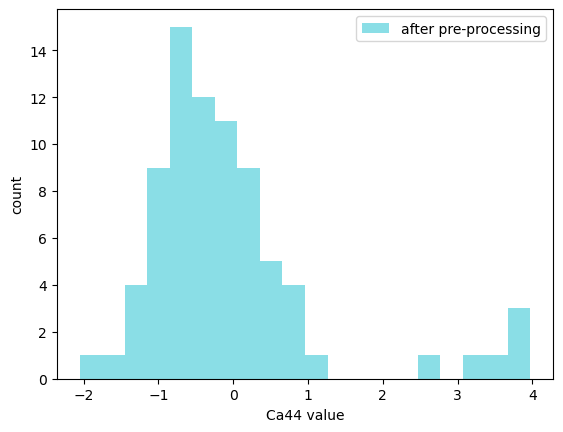

In [97]:
#plt.hist(obs[:, 0], bins=20, histtype='step', color='tab:purple', alpha=1, label='before pre-processing');
plt.hist(obs_zscore[:, 3], bins=20, color='tab:cyan', alpha=0.5, label='after pre-processing');
plt.xlabel('Ca44 value');
plt.ylabel('count');
#plt.xlim(-10,30000)
plt.legend();

#### Step 4. Calculate scores

In the previous steps we have explored the given data, split it into subsets and performed pre-processing. We call the 10 pre-processed values we now have for each observation the features. The next step is to go from these feature vectors to a score. In order to do this we have to make pairs of observations, both H1-true and H2-true, and calculate the scores based on their feature vectors. A score is meant to quantify the degree of (dis)similarity between a pair of observations.

##### Create pairs

The function create_pairs below creates one H1-true pair per subject, and one H2-true pair for each pair of different subjects.

In [98]:
def create_pairs(obs, ids):
    """
    Creates all possible pairs between the items represented by ids.
    The ids refer to the total set of observations given by obs.
    """
    # Create matrices with item IDs that refer to the total data set
    H1_ids = np.transpose(np.tile(np.unique(ids), (2, 1))) #.astype(int)
    H2_ids = np.asarray(list(combinations(np.unique(ids), 2)))

    # For H1-data: use the first repeat for each item in the first colum,
    # and the second repeat of that item in the second.
    # It is assumed: that obs is sorted first by item ID, then by repeat ID;
    # that all items have exactly 2 repeats; that there are no missing items.
    H1_obs_rep_1 = obs[2*(H1_ids[:,0]) - 2] #-44
    H1_obs_rep_2 = obs[2*(H1_ids[:,1]) - 1] #-44
    
    #H1_obs_rep_1 = pd.DataFrame(obs).iloc[list(range(0, 174, 2))].reset_index().drop(columns=['index']).values #Select the 0,2,4,etc. row of the obs data [list(range(0, 174, 2))]
    #H1_obs_rep_2 = pd.DataFrame(obs).iloc[list(range(1, 174, 2))].reset_index().drop(columns=['index']).values #Select the 1,3,5,etc. row of the obs data [list(range(1, 174, 2))]
    
    H1_obs_pairs = np.stack((H1_obs_rep_1, H1_obs_rep_2), axis=2)

    # For H2-data: use for both items their first repeats
    H2_obs_item_1 = obs[2*(H2_ids[:,0]) - 2] #-52
    H2_obs_item_2 = obs[2*(H2_ids[:,1]) - 2] #-52
    
    #H2_obs_item_1 = pd.DataFrame(obs).iloc[2*H2_ids[:,0] - 2].reset_index().drop(columns=['index']).values #Select the 0,2,4,etc. row of the obs data
    #H2_obs_item_2 = pd.DataFrame(obs).iloc[2*H2_ids[:,1] - 2].reset_index().drop(columns=['index']).values #Select the 1,3,5,etc. row of the obs data
    
    H2_obs_pairs = np.stack((H2_obs_item_1, H2_obs_item_2), axis=2)

    # Combine the H1 and H2 data, and create vector with classes: H1 and H2
    obs_pairs = np.concatenate((H1_obs_pairs, H2_obs_pairs))
    hypothesis = np.concatenate((np.array(['H1']*len(H1_ids)),
                            np.array(['H2']*len(H2_ids))))

    return obs_pairs, hypothesis

In [99]:
obs_pairs_train, hypothesis_train = create_pairs(obs_zscore, ids_train)
obs_pairs_select, hypothesis_select = create_pairs(obs_zscore, ids_select)

print(f'We have constructed {len(obs_pairs_train)} pairs in the training data, \
{int(sum(hypothesis_train=="H1"))} H1 and {int(sum(hypothesis_train=="H2"))} H2 pairs')
print(f'For the selection data we have {len(obs_pairs_select)} pairs, \
{int(sum(hypothesis_select=="H1"))} H1 and {int(sum(hypothesis_select=="H2"))} H2 pairs\n')

print('Looking at the values for the first pair, \n')
print(obs_pairs_train[0,:,:])
print('\nwe see this is just the concatenation of the feature vectors of the \
two observations on the first subject:\n')
print(obs_zscore[:2,:])

We have constructed 300 pairs in the training data, 24 H1 and 276 H2 pairs
For the selection data we have 28 pairs, 7 H1 and 21 H2 pairs

Looking at the values for the first pair, 

[[ 0.8114405   0.78832651]
 [ 0.82701632  0.71770568]
 [ 1.00349648  0.89242934]
 [ 0.95067067  0.88133929]
 [ 1.94197318  1.65798512]
 [ 1.55094842  1.5661049 ]
 [ 0.95717272  0.96330306]
 [ 1.77871821  1.84525736]
 [ 1.6456952   1.7321357 ]
 [ 1.78066409  1.75998051]
 [ 1.74922083  1.75831544]
 [-0.30315087 -0.61207229]
 [ 0.36728872  0.42785226]
 [ 0.99399206  1.00556918]
 [ 0.63919226  0.41238657]
 [ 1.0781768  -0.00515202]
 [ 1.05641962  1.12680612]
 [ 1.51990809  1.0861781 ]]

we see this is just the concatenation of the feature vectors of the two observations on the first subject:

[[ 0.8114405   0.82701632  1.00349648  0.95067067  1.94197318  1.55094842
   0.95717272  1.77871821  1.6456952   1.78066409  1.74922083 -0.30315087
   0.36728872  0.99399206  0.63919226  1.0781768   1.05641962  1.51990809]

Once we have the same-source and different-source pairs we have to compute the score per pair. We show two different ways.

##### Option A: Compute (dis)similarity score

We take the Manhattan distance. This is defined as the sum of the absolute differences of the features. Luckily, distances such as these are standard functions in the python package sklearn.

In [100]:
dissimilarity_scores_train = paired_manhattan_distances(obs_pairs_train[:,:,0], obs_pairs_train[:,:,1])
dissimilarity_scores_select = paired_manhattan_distances(obs_pairs_select[:,:,0], obs_pairs_select[:,:,1])

print('For the same first pair (H1 is true) shown above, we get the following features: \n')
print(obs_pairs_train[0,:,:])

print('\nWe calculate the absolute differences per feature:\n')
print(np.absolute(np.diff(obs_pairs_train[0,:,:], axis = 1)))
print('\nWhen summed, we get a relatively low absolute difference of\n')
print(dissimilarity_scores_train[0])

print('\n\nIf we do the same for the first H2-true pair, \n')
print(obs_pairs_train[hypothesis_train=="H2",:,:][0])
print('\nwe get a much higher distance of\n')
print(dissimilarity_scores_train[hypothesis_train=="H2"][0])

For the same first pair (H1 is true) shown above, we get the following features: 

[[ 0.8114405   0.78832651]
 [ 0.82701632  0.71770568]
 [ 1.00349648  0.89242934]
 [ 0.95067067  0.88133929]
 [ 1.94197318  1.65798512]
 [ 1.55094842  1.5661049 ]
 [ 0.95717272  0.96330306]
 [ 1.77871821  1.84525736]
 [ 1.6456952   1.7321357 ]
 [ 1.78066409  1.75998051]
 [ 1.74922083  1.75831544]
 [-0.30315087 -0.61207229]
 [ 0.36728872  0.42785226]
 [ 0.99399206  1.00556918]
 [ 0.63919226  0.41238657]
 [ 1.0781768  -0.00515202]
 [ 1.05641962  1.12680612]
 [ 1.51990809  1.0861781 ]]

We calculate the absolute differences per feature:

[[0.02311398]
 [0.10931065]
 [0.11106714]
 [0.06933138]
 [0.28398806]
 [0.01515648]
 [0.00613034]
 [0.06653915]
 [0.0864405 ]
 [0.02068357]
 [0.00909462]
 [0.30892143]
 [0.06056354]
 [0.01157711]
 [0.22680569]
 [1.08332881]
 [0.0703865 ]
 [0.43372999]]

When summed, we get a relatively low absolute difference of

2.996168919434168


If we do the same for the first H2-true pa

More generally, we see that *H*<sub>2</sub>-true pairs get higher dissimilarity scores, as expected:

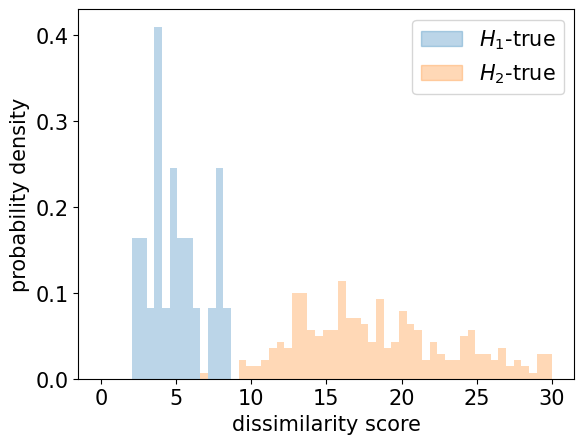

In [101]:
with lir.plotting.show() as ax:
    ax.score_distribution(scores=dissimilarity_scores_train, y=(hypothesis_train=='H1')*1, bins=np.linspace(0, 30, 60), weighted=True)
    plt.xlabel('dissimilarity score')
    H1_legend = mpatches.Patch(color='tab:blue', alpha=.3, label='$H_1$-true')
    H2_legend = mpatches.Patch(color='tab:orange', alpha=.3, label='$H_2$-true')
    ax.legend(handles=[H1_legend, H2_legend])

##### Option B: Compute machine learning score

Alternatively, we can fit a statistical model to compute scores. In this case, we use a support vector machine. First the absolute differences for each elemental value between the pairs of observations are computed. The support vector machine then assigns a score to each pair. The model aims to assign high scores to H1-true pairs and low scores to H2-true pairs.

In [102]:
from lir.transformers import AbsDiffTransformer

# machine learning models need a single vector as input. The AbsDiffTransformer takes two feature vectors,
# one for each subject of a pair, and returns the elementwise absolute differences
# The AbsDiffTransformer and support vector machine (SVC) are combined into a single pipeline using sklearns Pipeline class.
machine_learning_scorer = Pipeline([('abs_difference', AbsDiffTransformer()), ('classifier', SVC(probability=True))])

# the model has to be fit on the data
machine_learning_scorer.fit(obs_pairs_train, hypothesis_train=="H1")
# score can be computed using the 'predict_proba' function. This is another sklearn convention,
# which returns two columns of which we take the second using '[:,1]'
machine_learning_scores_train = machine_learning_scorer.predict_proba(obs_pairs_train)[:, 1]

The scores look like this:

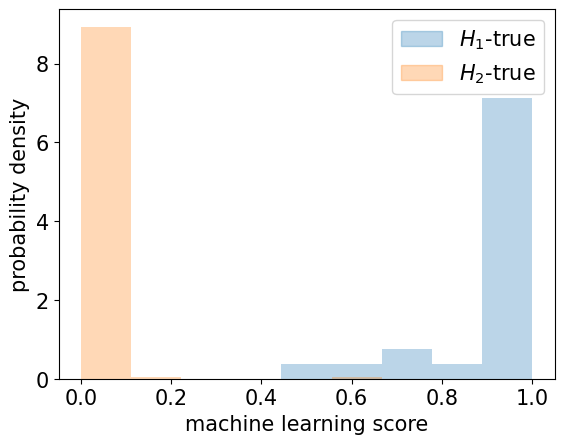

In [103]:
with lir.plotting.show() as ax:
    ax.score_distribution(scores=machine_learning_scores_train, y=(hypothesis_train=='H1')*1, bins=np.linspace(0, 1, 10), weighted=True)
    plt.xlabel('machine learning score')
    H1_legend = mpatches.Patch(color='tab:blue', alpha=.3, label='$H_1$-true')
    H2_legend = mpatches.Patch(color='tab:orange', alpha=.3, label='$H_2$-true')
    ax.legend(handles=[H1_legend, H2_legend])

In [104]:
print(f'For example, the machine learning score for the H1-true pair from option A is {round(machine_learning_scores_train[hypothesis_train=="H1"][0],8)}, and for the first H2-true pair {round(machine_learning_scores_train[hypothesis_train=="H2"][0],8)}. ')

For example, the machine learning score for the H1-true pair from option A is 0.98304279, and for the first H2-true pair 0.00085408. 


As expected, the H1-true pairs generally have lower dissimilarity scores than the H2-true pairs, while their machine learning scores are higher.

#### Step 5. Calculate LRs from scores

After step 4 we have a score for each pair. Two approaches exist to convert these scores to LRs. We show an example for each approach.

##### Generative approach

In the generative approach approach, we model the distribution of scores under H1 and under H2. Here, we use kernel density estimation (KDE) to do this. KDE is a way to estimate an unknown probability density by 'smoothing' the observed distribution. LiR defines classes called 'Calibrators' to perform the score to LR mapping.

In [105]:
kde_calibrator = lir.KDECalibrator(bandwidth='silverman')

To illustrate how this works, we plot the histograms for the scores under H1 and H2-true, together with the KDE fits.

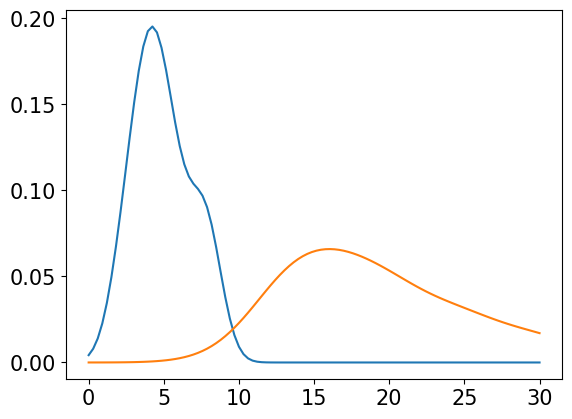

In [106]:
kde_calibrator.fit(dissimilarity_scores_train, hypothesis_train=="H1")
with lir.plotting.show() as ax:
    ax.calibrator_fit(kde_calibrator, score_range=[0,30]);

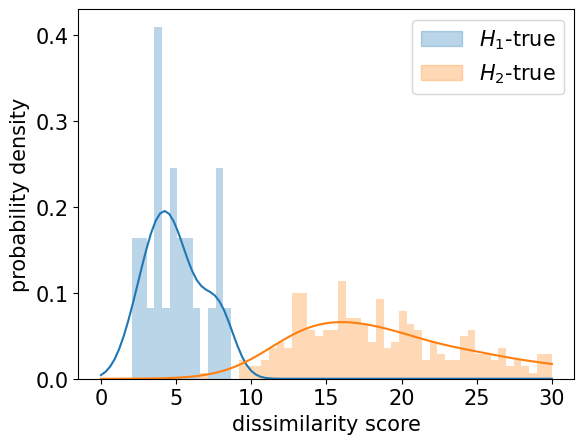

In [107]:
kde_calibrator.fit(dissimilarity_scores_train, hypothesis_train=="H1")
with lir.plotting.show() as ax:
    ax.calibrator_fit(kde_calibrator, score_range=[0, 30])
    ax.score_distribution(scores=dissimilarity_scores_train, y=(hypothesis_train=='H1')*1, bins=np.linspace(0, 30, 60), weighted=True)
    ax.xlabel('dissimilarity score')
    H1_legend = mpatches.Patch(color='tab:blue', alpha=.3, label='$H_1$-true')
    H2_legend = mpatches.Patch(color='tab:orange', alpha=.3, label='$H_2$-true')
    ax.legend(handles=[H1_legend, H2_legend])

Plot

In [108]:
Hypotheses_raw = pd.DataFrame([dissimilarity_scores_train, hypothesis_train=="H1"]).T

In [109]:
#np.array(Hypotheses[Hypotheses[1] == True][0])

In [110]:
H1 = Hypotheses_raw[Hypotheses_raw[1] == True]
H2 = Hypotheses_raw[Hypotheses_raw[1] == False]

In [111]:
Same_source = np.array(H1[0])
Diff_source = np.array(H2[0])

In [112]:
def plot_hist(data, n, color, binwidth=1):
    plt.hist(
        data, 
        bins=np.arange(np.floor(data.min()), data.max()+binwidth, binwidth),
        weights=np.repeat(1/n, len(data)),
        color=color
    )

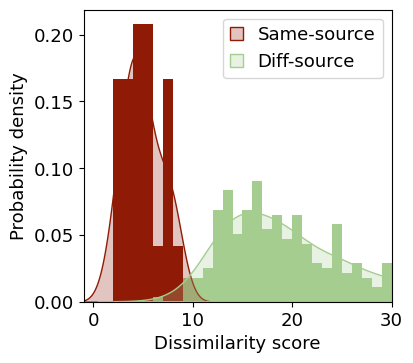

In [113]:
plt.figure(figsize=(4.4,4))

plt.xlabel('Dissimilarity score', fontsize = 13)
plt.ylabel('Probability density', fontsize = 13)

plot_hist(Same_source, len(Same_source), color='#8F1B07')
plot_hist(Diff_source, len(Diff_source), color='#A5CD90')

sns.kdeplot(Same_source, fill=True, color='#8F1B07', bw_adjust=1.2)
sns.kdeplot(Diff_source, fill=True, color='#A5CD90', bw_adjust=1)


plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

plt.xlim([-1,30])

plt.legend(['Same-source','Diff-source'], fontsize = 13, handlelength=0.7)

plt.gcf().subplots_adjust(left=0.20, bottom=0.15)

#plt.savefig('img/LR-score-Tapes-PVC-X2.svg') # Save image.

##### Discriminative approach

Alternatively, we can use other discriminative methods. Here we use logistic regression to map the score to posterior odds. This can be corrected for the amount of H1 and H2 data.

In [114]:
logreg_calibrator = lir.LogitCalibrator()

##### Bounding the LRs

The LR system may output values that seem too large or too small given the size of our data set. Several methods have been proposed mitigate this problem, by 'shrinking' the LRs towards 1. Here we show how to use empirical lower and upper bounds (ELUB) to limit the minimum and maximum values the LR system can output. Using LiR, we can stack this 'ELUBbounder' on any calibrator we have.

In [115]:
bounded_kde_calibrator = lir.ELUBbounder(kde_calibrator)
bounded_logreg_calibrator = lir.ELUBbounder(logreg_calibrator)

##### Illlustration of scores to LRs

To illustrate the score to LR mapping, we plot how the dissimilarity scores are mapped to LRs (using a log10 scale). We print the values of the ELUB bounds - these are visible in the plot as the minimum and maximum values the LRs obtain (horizontal lines).

One thing to note is that the dark green line (logistic regression) never goes up. This is a desirable property, it makes sense that more extreme scores correspond to more extreme LRs. In contrast, the light green line (kernel density estimation (KDE)) shows several humps, e.g. at score=0 and score=2. This means that, counterintuitively, sometimes a higher dissimilarity leads to a lower LR. Here we don't 'fix' this (e.g. by adjusting the bandwidth of the KDE), but be aware that some methods for transforming scores to LRs can have this property.

ELUB log(LR) bounds for logreg are -1.38 and 2.32
ELUB log(LR) bounds for kde are -1.38 and 2.16


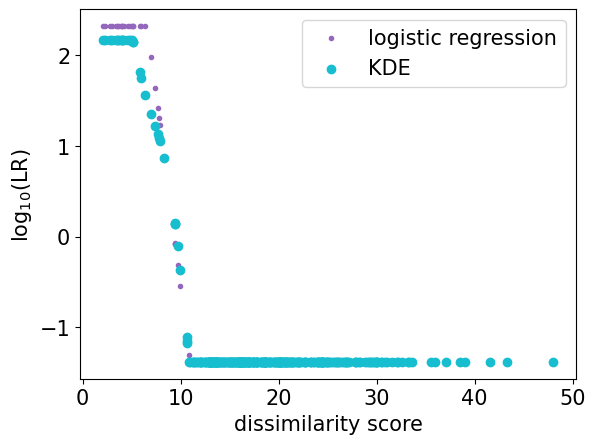

In [116]:
lrs_train_logreg = bounded_logreg_calibrator.fit_transform(dissimilarity_scores_train, hypothesis_train=="H1")
lrs_train_kde = bounded_kde_calibrator.fit_transform(dissimilarity_scores_train, hypothesis_train=="H1")

plt.scatter(dissimilarity_scores_train, np.log10(lrs_train_logreg), color='tab:purple', marker=".", label='logistic regression')
plt.scatter(dissimilarity_scores_train, np.log10(lrs_train_kde), color='tab:cyan', label = 'KDE')
#plt.xlim([0, 5])

plt.legend()

plt.xlabel('dissimilarity score')
plt.ylabel('log$_{10}$(LR)')

print(f'ELUB log(LR) bounds for logreg are {np.log10(bounded_logreg_calibrator._lower_lr_bound):.2f} and {np.log10(bounded_logreg_calibrator._upper_lr_bound):.2f}')
print(f'ELUB log(LR) bounds for kde are {np.log10(bounded_kde_calibrator._lower_lr_bound):.2f} and {np.log10(bounded_kde_calibrator._upper_lr_bound):.2f}')

Note that for the generative approach, the score to LR function is not monotonous. This is something we do not expect from a score to LR function, and possibly could be solved by using a kernel density estimator with a greater bandwidth.

#### Step 6. Select best LR system

In this step, we compute the performance of each LR system defined on the selection data. For this we use the CalibratedScorer class from LiR, which allows you to combine computing scores and transforming to LRs in one step. A CalibratedScorer needs two parts: a function or machine learning model to compute scores, and a Calibrator to transform the scores to LRs.

We define a function to give us the histograms of the LRs, the PAV plot, the ELUB bounds and the Cllr:

In [117]:
def show_performance(lrs, hypothesis, calibrator):
  hypothesis=(hypothesis=='H1')*1 # convert to 0 or 1 for technical reasons

  # show the distribution of LRs together with the ELUB values
  print('Histogram of the LRs:\n')

  with lir.plotting.show() as ax:
      ax.lr_histogram(lrs, hypothesis)
      H1_legend = mpatches.Patch(color='tab:blue', alpha=.25, label='$H_1$-true')
      H2_legend = mpatches.Patch(color='tab:orange', alpha=.25, label='$H_2$-true')
      ax.legend(handles=[H1_legend, H2_legend])

  print(f'\n ELUB log(LR) bounds are {np.log10(calibrator._lower_lr_bound):.2f} and {np.log10(calibrator._upper_lr_bound):.2f} \n')

  print('PAV plot (closer to the line y=x is better):\n')
  # show the PAV plot (closer to the line y=x is better)
  with lir.plotting.show() as ax:
      ax.pav(lrs, hypothesis)

  # print the quality of the system as log likelihood ratio cost (lower is better)
  print(f'\n The log likelihood ratio cost is {lir.metrics.cllr(lrs, hypothesis):.3f} (lower is better)\n')

##### Option 1: Manhattan distance + KDE

Histogram of the LRs:



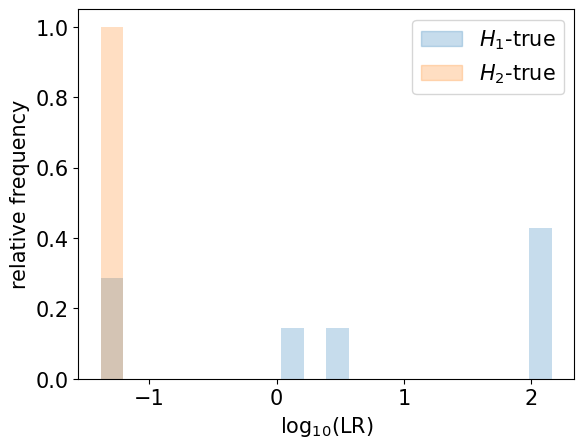


 ELUB log(LR) bounds are -1.38 and 2.16 

PAV plot (closer to the line y=x is better):



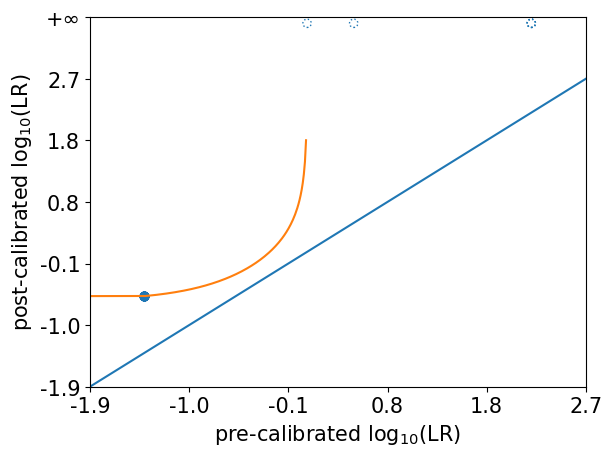


 The log likelihood ratio cost is 0.781 (lower is better)



In [118]:
# We define the CalibratedScorer. We use the standard sklearn function paired_manhattan_distance to compute the scores,
# and an ELUB bounded KDE calibrator to transform to LRs.
lr_system = lir.CalibratedScorer(paired_manhattan_distances, bounded_kde_calibrator)
# We fit the entire lr system
lr_system.fit(obs_pairs_train, hypothesis_train=="H1")

# and compute the LRs on the selection data
lrs_select = lr_system.predict_lr(obs_pairs_select)

# this is how well the system performs
show_performance(lrs_select, hypothesis_select, lr_system.calibrator)

##### Option 2: Manhattan distance + logistic regression

Histogram of the LRs:



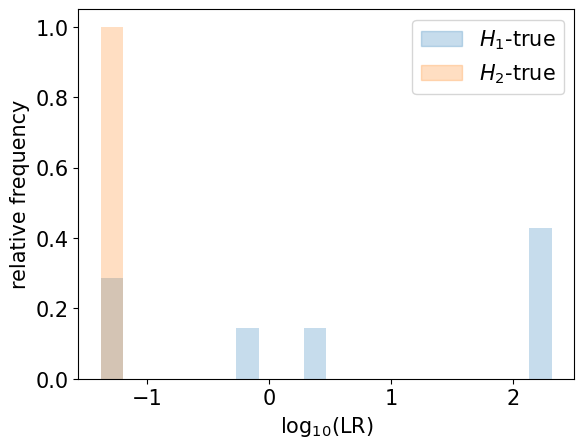


 ELUB log(LR) bounds are -1.38 and 2.32 

PAV plot (closer to the line y=x is better):



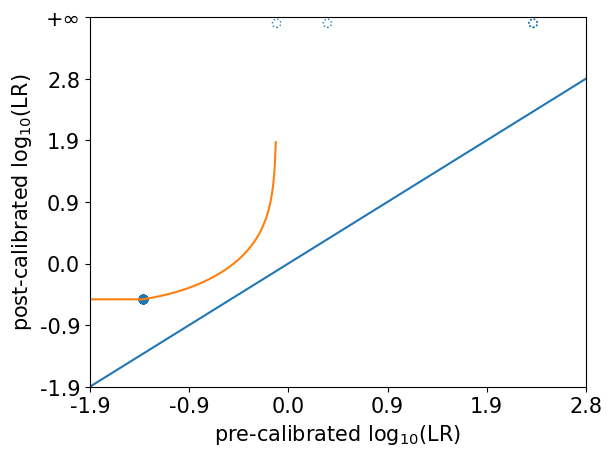


 The log likelihood ratio cost is 0.815 (lower is better)



In [119]:
# We define the CalibratedScorer. We use the standard sklearn function paired_manhattan_distance to compute the scores,
# and an ELUB bounded logistic regression calibrator to transform to LRs.
lr_system = lir.CalibratedScorer(paired_manhattan_distances, bounded_logreg_calibrator)
# We fit the entire lr system
lr_system.fit(obs_pairs_train, hypothesis_train=="H1")

# and compute the LRs on the selection data
lrs_select = lr_system.predict_lr(obs_pairs_select)

# this is how well the system performs
show_performance(lrs_select, hypothesis_select, lr_system.calibrator)

##### Option 3: support vector machine + KDE

Histogram of the LRs:



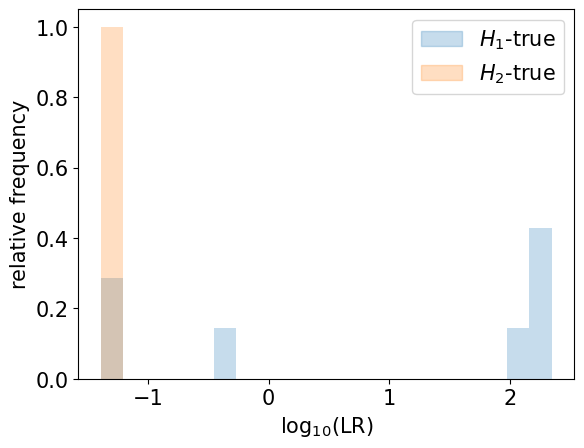


 ELUB log(LR) bounds are -1.39 and 2.35 

PAV plot (closer to the line y=x is better):



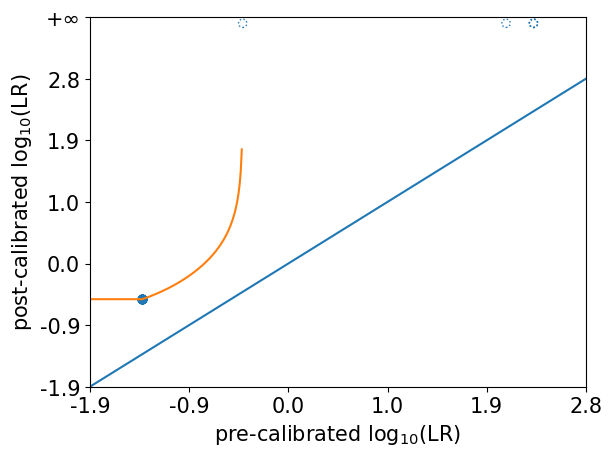


 The log likelihood ratio cost is 0.834 (lower is better)



In [120]:
# The whole LR system consists of computing the score and then mapping the scores to lrs.
# We use the machine learning scorer introduced in step 4
scorer = Pipeline([('abs_difference', AbsDiffTransformer()), ('classifier', SVC(probability=True))])

lr_system = lir.CalibratedScorer(scorer, bounded_kde_calibrator)

# we fit the whole system. When fitting (=training) a CalibratedScorer, both the machine learning model and the transformation to LRs are trained on the supplied data
lr_system.fit(obs_pairs_train, hypothesis_train=="H1")

lrs_select = lr_system.predict_lr(obs_pairs_select)

show_performance(lrs_select, hypothesis_select, lr_system.calibrator)

##### Option 4: support vector machine + logistic regression

Histogram of the LRs:



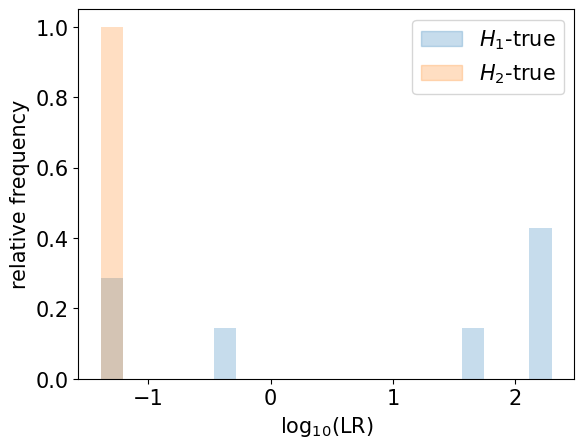


 ELUB log(LR) bounds are -1.39 and 2.30 

PAV plot (closer to the line y=x is better):



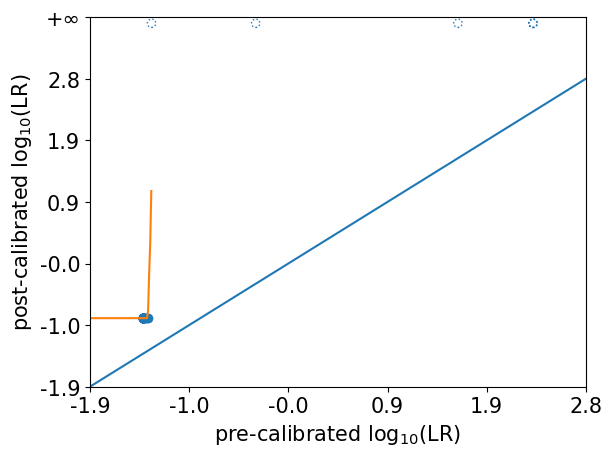


 The log likelihood ratio cost is 0.798 (lower is better)



In [121]:
# The whole LR system consists of computing the score and then mapping the scores to lrs
scorer = Pipeline([('abs_difference', AbsDiffTransformer()), ('classifier', SVC(probability=True))])

lr_system = lir.CalibratedScorer(scorer, bounded_logreg_calibrator)
# we fit the whole system
lr_system.fit(obs_pairs_train, hypothesis_train=="H1")
lrs_select = lr_system.predict_lr(obs_pairs_select)

show_performance(lrs_select, hypothesis_select, lr_system.calibrator)

##### Final selection

In [122]:
# Manhattan distance + logistic regression

Histogram of the LRs:



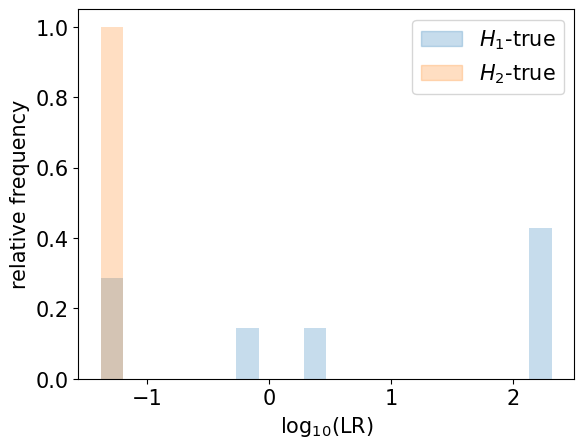


 ELUB log(LR) bounds are -1.38 and 2.32 

PAV plot (closer to the line y=x is better):



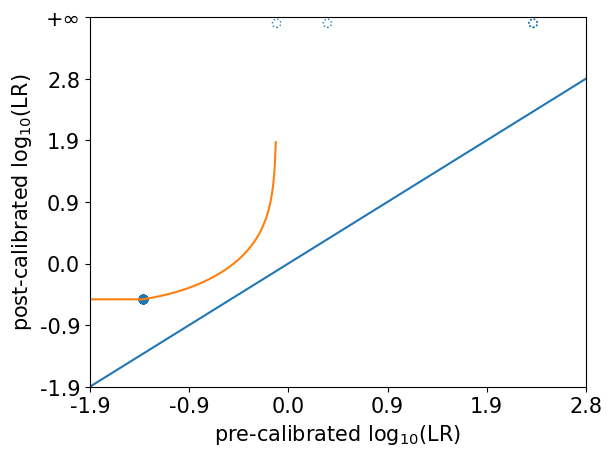


 The log likelihood ratio cost is 0.815 (lower is better)



In [123]:
# We define the CalibratedScorer. We use the standard sklearn function paired_manhattan_distance to compute the scores,
# and an ELUB bounded logistic regression calibrator to transform to LRs.
lr_system = lir.CalibratedScorer(paired_manhattan_distances, bounded_logreg_calibrator)
# We fit the entire lr system
lr_system.fit(obs_pairs_train, hypothesis_train=="H1")

# and compute the LRs on the selection data
lrs_select = lr_system.predict_lr(obs_pairs_select)

# this is how well the system performs
show_performance(lrs_select, hypothesis_select, lr_system.calibrator)

#### Step 7. Validate selected LR system

After selecting the (best) model, you should assess the performance of the system on the validation set.

##### Construct the selected system

Since we want to build the selected model based on as much data as possible, we add the selection set to the training set and use the combination to train the LR system used for validation.

In [124]:
# create the combined data set
obs_train_select = obs[train_select_indices]
ids_train_select = ids[train_select_indices]

# step 3 pre-processing: normalise
z_score_transformer.fit(obs_train_select)
obs_zscore = z_score_transformer.transform(obs)

# step 4: combine the pairs into one feature vector by taking the absolute difference
obs_pairs_train_select, hypothesis_train_select = create_pairs(obs_zscore, ids_train_select)
obs_pairs_val, hypothesis_val = create_pairs(obs_zscore, ids_val)

selected_lr_system = lir.CalibratedScorer(machine_learning_scorer, lir.ELUBbounder(lir.KDECalibrator(bandwidth='silverman')))
#selected_lr_system = lir.CalibratedScorer(machine_learning_scorer, lir.KDECalibrator(bandwidth='silverman')) #

# step 4+5 combined: we fit the whole system
selected_lr_system.fit(obs_pairs_train_select, hypothesis_train_select=='H1')

# compute the LRs on the validation data
lrs_val = selected_lr_system.predict_lr(obs_pairs_val)

##### Calculate system performance

Plot

In [125]:
Hypotheses = pd.DataFrame([np.log10(lrs_val), hypothesis_val]).T

In [126]:
H1 = Hypotheses[Hypotheses[1] == 'H1']
H2 = Hypotheses[Hypotheses[1] == 'H2']

In [127]:
Same_source = np.array(H1[0])
Diff_source = np.array(H2[0])

In [128]:
def plot_hist(data, n, color, binwidth=0.2):
    plt.hist(
        data, 
        bins=np.arange(np.floor(data.min()), data.max()+binwidth, binwidth),
        weights=np.repeat(1/n, len(data)),
        color=color
    )

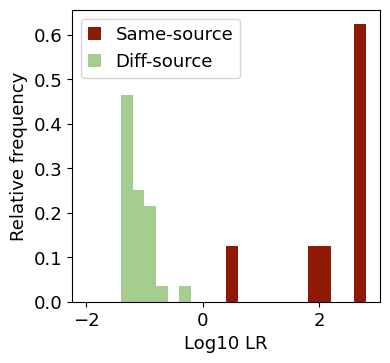

In [129]:
plt.figure(figsize=(4.4,4))

plt.xlabel('Log10 LR', fontsize = 13)
plt.ylabel('Relative frequency', fontsize = 13)

plot_hist(Same_source, len(Same_source), color='#8F1B07')
plot_hist(Diff_source, len(Diff_source), color='#A5CD90')

plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)

#plt.xlim([-4,5])

plt.legend(['Same-source','Diff-source'], fontsize = 13, handlelength=0.7)

plt.gcf().subplots_adjust(left=0.20, bottom=0.15)

#plt.savefig('img/LR-score2-Tapes-PVC-X.svg') # Save image.

Histogram of the LRs:



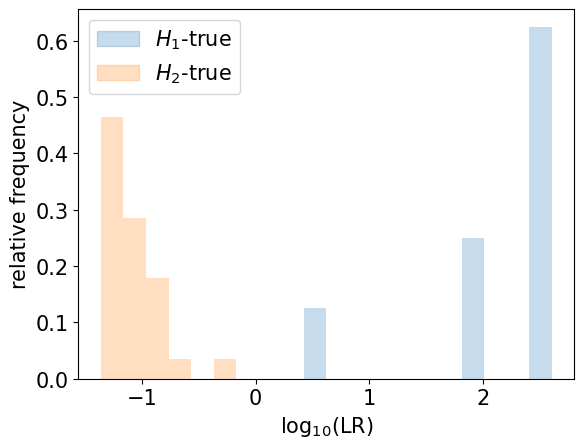


 ELUB log(LR) bounds are -1.36 and 2.61 

PAV plot (closer to the line y=x is better):



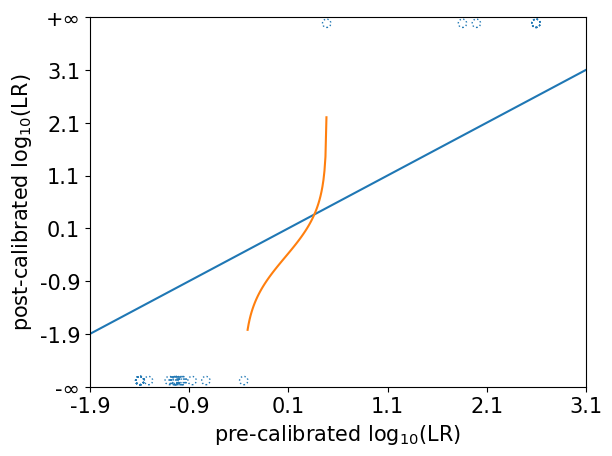


 The log likelihood ratio cost is 0.090 (lower is better)



In [130]:
# we always inspect the characteristics we also look at in selection
show_performance(lrs_val, hypothesis_val, selected_lr_system.calibrator)

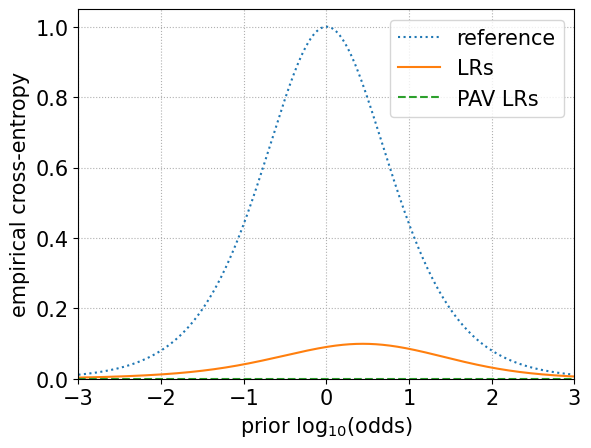

In [131]:
# There are many other characteristics that we may want to inspect, such as the empirical cross entropy (ECE) plot.
with lir.plotting.show() as ax:
      ax.ece(lrs_val, hypothesis_val=='H1')

In [132]:
lir.metrics.cllr(lrs_val, hypothesis_val=='H1')

0.09023336016997223

In [133]:
lir.metrics.cllr_min(lrs_val, hypothesis_val=='H1')

0.0

#### Step 8. Construct casework LR system

In [134]:
# create new pairs for the combined data
obs_zscore = z_score_transformer.fit_transform(obs)
obs_pairs, hypothesis = create_pairs(obs_zscore, ids)

# fit the same system on all the data
selected_lr_system.fit(obs_pairs, hypothesis=='H1');

In [135]:
observation_1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
observation_2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#observation_1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#observation_2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

manual_entered_data = np.moveaxis(np.array([z_score_transformer.transform([observation_1,observation_2])]),1,-1)

print(f'The LR obtained is {selected_lr_system.predict_lr(manual_entered_data)[0]}')

The LR obtained is 593.366772688739


#### Visualization

In the validation, we hope to see performance comparable to that on the selection data. This is the case here, with Cllr, ELUB bounds and LR distributions looking very similar to those we saw in step 6. The PAV plot looks reasonable, with the data points mostly following the line y=x. There are a few datapoint that lie under this line, indicating a slight overconfidence of the system in this LR range.The ECE plot in Figure shows that the LRs are, for any prior odds, performing substantially better than a system where LR=1 (the reference system).

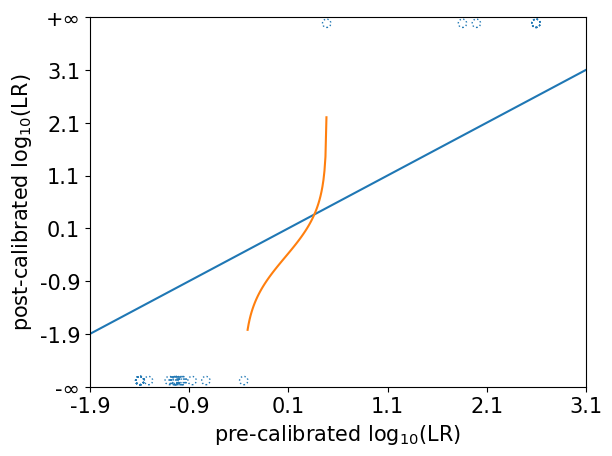

In [136]:
with lir.plotting.show() as ax:
      ax.pav(lrs_val, hypothesis_val=='H1')

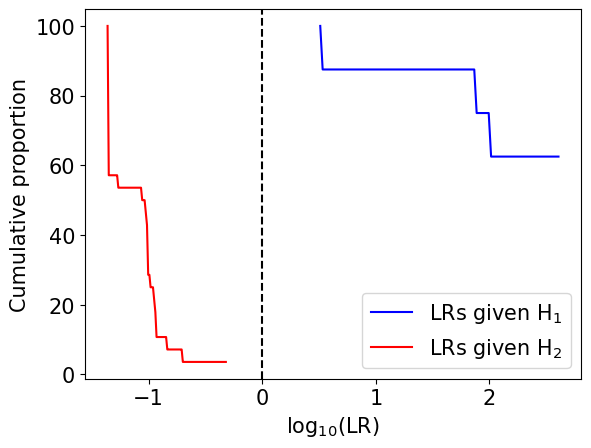

In [137]:
#Option 1
# with lir.plotting.show() as ax:
#       ax.tippett(lrs_val, hypothesis_val=='H1')

#Option 2
log_lrs = np.log10(lrs_val)

lr_0, lr_1 = log_lrs[hypothesis_val == "H2"], log_lrs[hypothesis_val == "H1"]
xplot0 = np.linspace(np.min(lr_0), np.max(lr_0), 100)
xplot1 = np.linspace(np.min(lr_1), np.max(lr_1), 100)
perc0 = (sum(i >= xplot0 for i in lr_0) / len(lr_0)) * 100
perc1 = (sum(i >= xplot1 for i in lr_1) / len(lr_1)) * 100
ax = plt
ax.plot(xplot1, perc1, color='b', label='LRs given $\mathregular{H_1}$')
ax.plot(xplot0, perc0, color='r', label='LRs given $\mathregular{H_2}$')
ax.axvline(x=0, color='k', linestyle='--')
ax.set_xlabel('log$_{10}$(LR)')
ax.set_ylabel('Cumulative proportion')
ax.legend()